# モデリング結果の基礎集計とそれによるモデル選定のチューニング方針決めノートブック

## plusでレビューも行う．分析内容も含めて確認的な意味合いが多い．

In [30]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt

import seaborn
from pandas import DataFrame
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler #アンダーサンプリング用
from sklearn.model_selection import train_test_split
import pickle
# 機械学習用
from sklearn.cluster import KMeans #クラスタリング用
from sklearn.ensemble import RandomForestClassifier#ランダムフォレスト
from copy import deepcopy as cp
from sklearn.linear_model import LogisticRegression
import time
import datetime
from dateutil.relativedelta import relativedelta
import os #ディレクトリ作成用
import xgboost as xgb
import sys
from sklearn.preprocessing import StandardScaler#モデルの評価用に標準化する関数
import scipy.stats#モデルの評価用に標準化する関数
import warnings

#自作のモジュールのインポート
sys.path.append("..")
import module.master as master
import module.modeling_scores as modeling


## なんかいい感じの分析用の関数

In [31]:
def get_season_date(now_date):#日付(datetime型)を渡すと，その日付で購買予測を行う際に使用するデータの区間を返す関数
    use_data_year=now_date.year
    if (now_date.month>=1)and(now_date.month<4):
        use_data_month=1
    elif (now_date.month>=4)and(now_date.month<7):
        use_data_month=4
    elif (now_date.month>=7)and(now_date.month<10):
        use_data_month=7
    elif (now_date.month>=10):
        use_data_month=10
    else:
        print('what???????')
    use_data_date=datetime.datetime(year=use_data_year, month=use_data_month,day=1)
    return use_data_date


def get_4_section_dt(now_date):#今いる区間から直近4区間の開始日をリストで返してくれる関数
    now_sec_date=get_season_date(now_date)
    diff_sec_stdates=[0]*4
    for i in range(len(diff_sec_stdates)):
        diff_sec_stdates[3-i]=now_sec_date- relativedelta(months=3*(i+1))#古い順に日付を入れていく
    return diff_sec_stdates

def get_feature_weights(score_final_df):#相関係数を変数の重みとして取得する関数，（1comあたり1行のdfを返す．）(引数として一つ前の区間,もしくは昨年同月区間のfinalありスコアのdfを渡す)
    plus_m_th=1
    num_hit_th=3
    feature_weights_df=pd.DataFrame()
    for com in sorted(score_final_df['target_com'].value_counts().sort_index().index):
        target_com_df=score_final_df[score_final_df['target_com']==com]
        #ざっと切り捨て，あまりに少ないのは適さないと思うので消す
        target_com_df=target_com_df[target_com_df['plus_month_num_test']>=plus_m_th].copy()#収益がプラスだった月の数で切り捨てる
        target_com_df=target_com_df[target_com_df['num_hit_test']>=num_hit_th].copy()#的中した予測の数で切り捨てる，大体一カ月に一件くらいをイメージ
        target_com_corr=target_com_df.corr()
        target_com_weights=target_com_corr.loc['gain_final']['total_get_test':'diff_mea_med_test']#相関係数を代用した変数ごとの重みづけ        
        feature_weights_df=feature_weights_df.append(target_com_weights)
    feature_weights_df['target_com']=score_final_df['target_com'].value_counts().sort_index().index
    feature_weights_df=feature_weights_df.set_index('target_com')
    feature_weights_df=feature_weights_df.fillna(0)
    return feature_weights_df


def add_std_score(good_model_df,feature_weights):#偏差値と相関係数をもとにしたスコアを与える
    add_score_df=pd.DataFrame()
    for com in sorted(good_model_df['target_com'].value_counts().sort_index().index):
        target_com_df=good_model_df[good_model_df['target_com']==com]
        #display(feature_weights)
        for f_name,weight in feature_weights.items():
            target_com_df.loc[:,'{}_score'.format(f_name)]=scipy.stats.zscore(target_com_df['{}'.format(f_name)].values)
            target_com_df.loc[:,'{}_score'.format(f_name)]=target_com_df['{}_score'.format(f_name)]*weight
        target_com_df=target_com_df.fillna(0)
        target_com_df['score']=0
        for f_name in feature_weights.index:
            target_com_df['score']=target_com_df['score']+target_com_df['{}_score'.format(f_name)]
        #display(target_com_df)
        add_score_df=pd.concat([add_score_df, target_com_df], axis=0)#きめのパラメータで切り落としたので結合
    
    return add_score_df

def add_std_score_DFversion(good_model_df,feature_weights_df):#偏差値と相関係数をもとにしたスコアを与える
    add_score_df=pd.DataFrame()
    for com in sorted(good_model_df['target_com'].value_counts().sort_index().index):
        target_com_df=good_model_df[good_model_df['target_com']==com]
        feature_weights=feature_weights_df.loc[com].copy()
        #display(feature_weights)
        for f_name,weight in feature_weights.items():
            target_com_df.loc[:,'{}_score'.format(f_name)]=scipy.stats.zscore(target_com_df['{}'.format(f_name)].values)
            target_com_df.loc[:,'{}_score'.format(f_name)]=target_com_df['{}_score'.format(f_name)]*weight
        target_com_df=target_com_df.fillna(0)
        target_com_df['score']=0
        for f_name in feature_weights.index:
            target_com_df['score']=target_com_df['score']+target_com_df['{}_score'.format(f_name)]
        #display(target_com_df)
        add_score_df=pd.concat([add_score_df, target_com_df], axis=0)#きめのパラメータで切り落としたので結合
    
    return add_score_df


def select_use_model(model_std_score_df):#相関係数と標準偏差によって与えられたscoreをもとに最終的に使用するモデルを選定する関数
    use_model_df=pd.DataFrame()
    for com in sorted(model_std_score_df['target_com'].value_counts().index):
        target_com_df=model_std_score_df[model_std_score_df['target_com']==com].copy()
        com_selected_row=target_com_df.sort_values('score', ascending=False).iloc[:1]
        #use_model_df=pd.concat([use_model_df, com_selected_row], axis=0)#きめのパラメータで切り落としたので結合
        use_model_df=use_model_df.append(com_selected_row,ignore_index=True)
    return use_model_df


def twin_plt(x,y1,y2,x_n,y1_n,y2_n):#2本軸でのグラフの描写
    fig = plt.figure(figsize=(19,8))
    plt.tick_params(colors='black')
    plt.rcParams["font.size"] = 18
    
    ax1 = fig.add_subplot()
    fig.set_facecolor(color='white')
    ax1.plot(x, y1,label=y1_n, marker="o")
    ax1.tick_params()
    plt.ylim(80, 200)
    ax2 = ax1.twinx()
    #print(y2)
    ax2.plot(x, y2,label=y2_n,color='red', marker="*")
    ax1.axhline(100,ls = "-.",color='green')
    #ax2.tick_params(colors='white')
    ax2.tick_params()

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='lower center')

    #ax1.set_xlabel(x_n,color='white')
    #ax1.set_ylabel(y1_n,color='white')
    #ax2.set_ylabel(y2_n,color='white')
    ax1.set_xlabel(x_n)
    ax1.set_ylabel(y1_n)
    ax2.set_ylabel(y2_n)
    plt.show()
    return None

In [45]:
#分析系
def get_num_plus_model_com(score_df):#スコアシートを渡して，プラスだったモデルの数と，comの数と割合を返してくる(series)関数
    analysis_s=pd.Series(dtype='object')
    analysis_s['num_plus_model']=len(score_df[score_df['gain_final']>105])
    analysis_s['plus_model_per']=(len(score_df[score_df['gain_final']>105])/len(score_df))*100
    analysis_s['num_plus_com']=len(score_df[score_df['gain_final']>105]['target_com'].value_counts().index)
    analysis_s['plus_com_per']=(len(score_df[score_df['gain_final']>105]['target_com'].value_counts().index)/len(score_df['target_com'].value_counts().index))*100
    return analysis_s

def serch_group(models_df):#モデルシートのパラメータをもとに，パラメータが連続している範囲内で同じ集団とし，集団番号を与える関数
    add_number_df=models_df.copy()
    add_number_df["group_num"]=0
    g_num=0
    g_num_arr=[0]*len(add_number_df)
    diff_index=-1
    i=0
    for index,row in add_number_df.iterrows():
        if index==diff_index+1:
            g_num_arr[i]=g_num
            diff_index=index#現在のインデックスを一つ前として保存
        elif index>diff_index+1:
            g_num=1+g_num
            g_num_arr[i]=g_num
            diff_index=index#現在のインデックスを一つ前として保存
        else:
            print('???????????????????????????????????')
        i+=1
    add_number_df["group_num"]=g_num_arr
    return add_number_df


def get_same_para_model(selected_model_df,now_year_score_df):
    use_models_df=pd.DataFrame()
    for index,row in selected_model_df.iterrows():
        target_df=now_year_score_df[now_year_score_df["target_com"]==row['target_com']].copy()
        target_df=target_df[target_df['threshold']==row['threshold']].copy()
        target_df=target_df[target_df['depth']==row['depth']].copy()
        target_df=target_df[target_df['target_per']==row['target_per']].copy()
        use_models_df=pd.concat([use_models_df,target_df])
    return use_models_df


#可視化系
def df_twin_plt(df,x_n,y1_n,y2_n):#2本軸でのグラフの描写
    fig = plt.figure(figsize=(19,8))
    plt.tick_params(colors='black')
    plt.rcParams["font.size"] = 18
    fig.set_facecolor(color='white')
    
    x=df[x_n].values
    y1=df[y1_n].values
    y2=df[y2_n].values
    
    ax1 = fig.add_subplot()
    ax1.plot(x, y1,label=y1_n, marker="o")
    ax1.tick_params()
    ax2 = ax1.twinx()
    #print(y2)
    ax2.plot(x, y2,label=y2_n,color='red', marker="*")
    #ax2.tick_params(colors='white')
    ax2.tick_params()

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2)

    #ax1.set_xlabel(x_n,color='white')
    #ax1.set_ylabel(y1_n,color='white')
    #ax2.set_ylabel(y2_n,color='white')
    ax1.set_xlabel(x_n)
    ax1.set_ylabel(y1_n)
    ax2.set_ylabel(y2_n)
    plt.show()
    return None

def df_hist_plt(df,target_col,num_bin=50,ylims=None):#2本軸でのグラフの描写
    #ylims:縦軸の範囲をセットする引数
    target_vals=df[target_col].values
    
    #グラフの処理
    fig = plt.figure(figsize=(19,8))
    plt.tick_params(colors='black')
    plt.rcParams["font.size"] = 18
    fig.set_facecolor(color='white')
    
    ax = fig.add_subplot()
    ax.hist(target_vals, bins=num_bin)
    ax.set_title(target_col)
    ax.set_xlabel('step')
    ax.set_ylabel('num_values')
    if ylims!=None:
        ax.set_ylim(ylims[0],ylims[1])
    plt.show()
    return None

def df_triple_plt(df,x_n,y1_1_n,y1_2_n,y2_1_n,y2_2_n):#3本軸でのグラフの描写(y1 一軸，y2_1.y2_2で二軸で計３軸,本数は4本)
    fig = plt.figure(figsize=(19,8))
    plt.tick_params(colors='black')
    plt.rcParams["font.size"] = 18
    fig.set_facecolor(color='white')
    
    x=df[x_n].values
    y1_1=df[y1_1_n].values
    y1_2=df[y1_2_n].values
    
    y2_1=df[y2_1_n].values
    y2_2=df[y2_2_n].values
    
    ax1 = fig.add_subplot()
    ax1.plot(x, y1_1,label=y1_1_n,color='orange', marker="o")
    ax1.plot(x, y1_2,label=y1_2_n,color='red', marker="o")
    #ax1.tick_params()
    
    ax2 = ax1.twinx()#右側の軸（一本目）の生成
    ax2.plot(x, y2_1,label=y2_1_n,color='blue', marker="*")
    ax2.tick_params()
    
    ax3 = ax1.twinx()#右側の軸（２本目）の生成
    ax3.plot(x, y2_2,label=y2_2_n,color='skyblue', marker="*")
    ax3.tick_params()

    plt.xticks(color="None")
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    h3, l3 = ax3.get_legend_handles_labels()
    ax1.legend(h1+h2+h3, l1+l2+l3)
    ax1.set_xlabel(x_n)
    ax1.set_ylabel("[{} , {}]".format(y1_1_n,y1_2_n))
    ax2.set_ylabel(y2_1_n)
    ax3.set_ylabel(y2_2_n)
    ax3.spines["right"].set_position(("axes", 1.08))
    plt.show()
    return None

In [33]:
place_master=master.get_place_master()
place_names=[place_name for place_name in place_master.values()]#会場名のみを収納した配列

# 基礎集計



## 超絶基礎集計，recent periodスコアシートの全体のplusのモデル数,com数をまとめる

### recent

<ipython-input-32-4b8d49003a51>:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


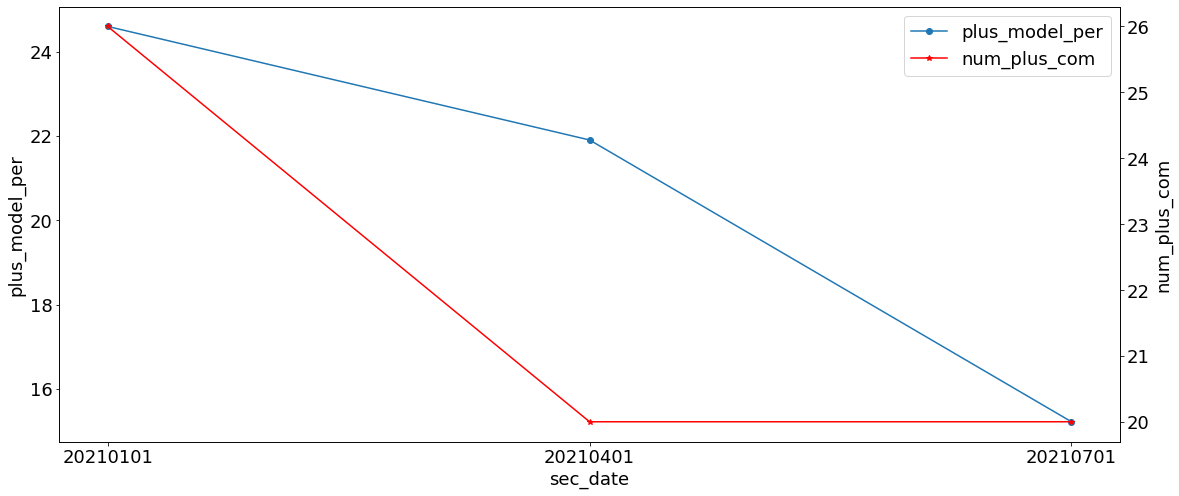

<ipython-input-32-4b8d49003a51>:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


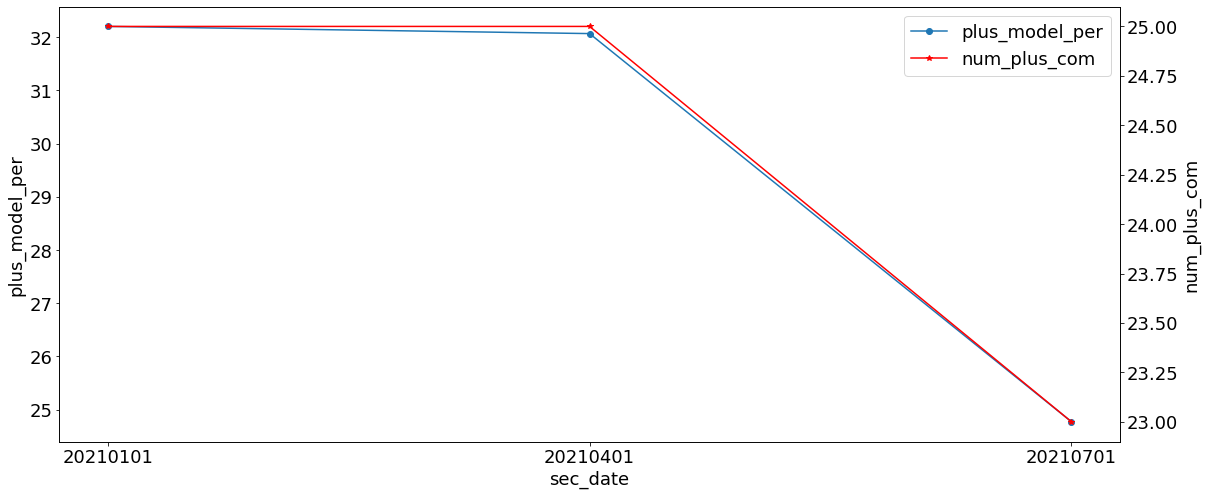

<ipython-input-32-4b8d49003a51>:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


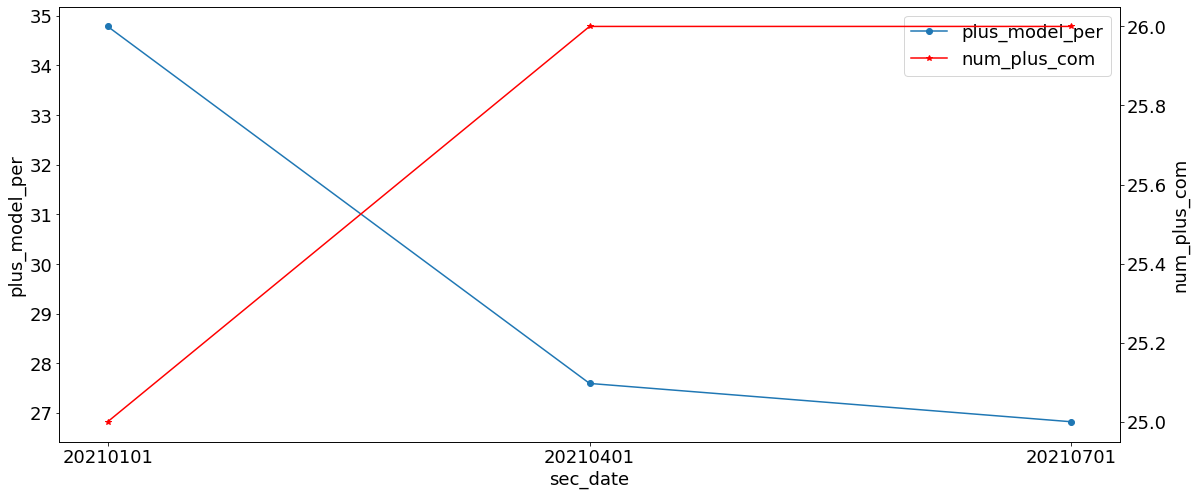

<ipython-input-32-4b8d49003a51>:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


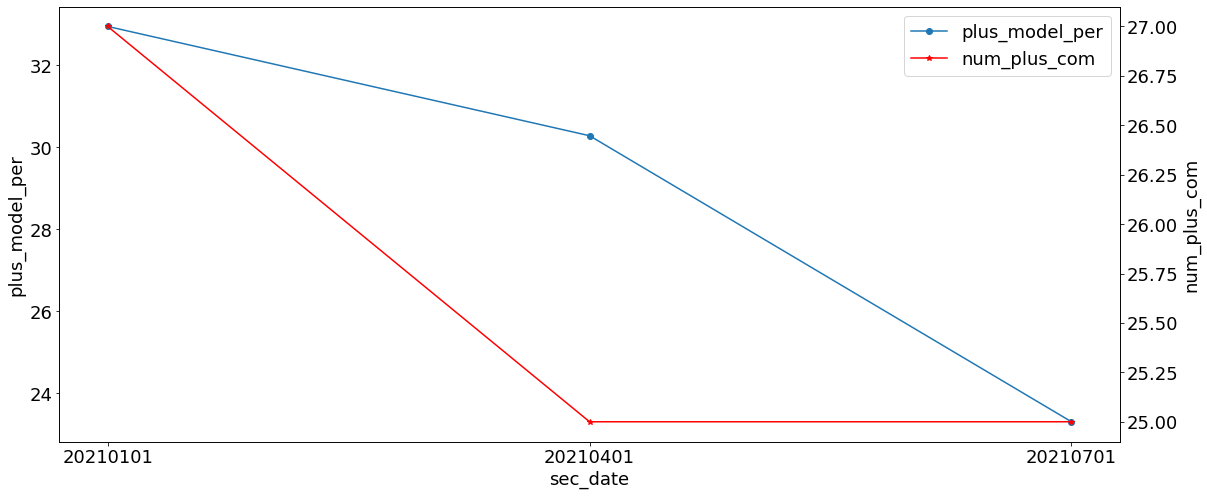

<ipython-input-32-4b8d49003a51>:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


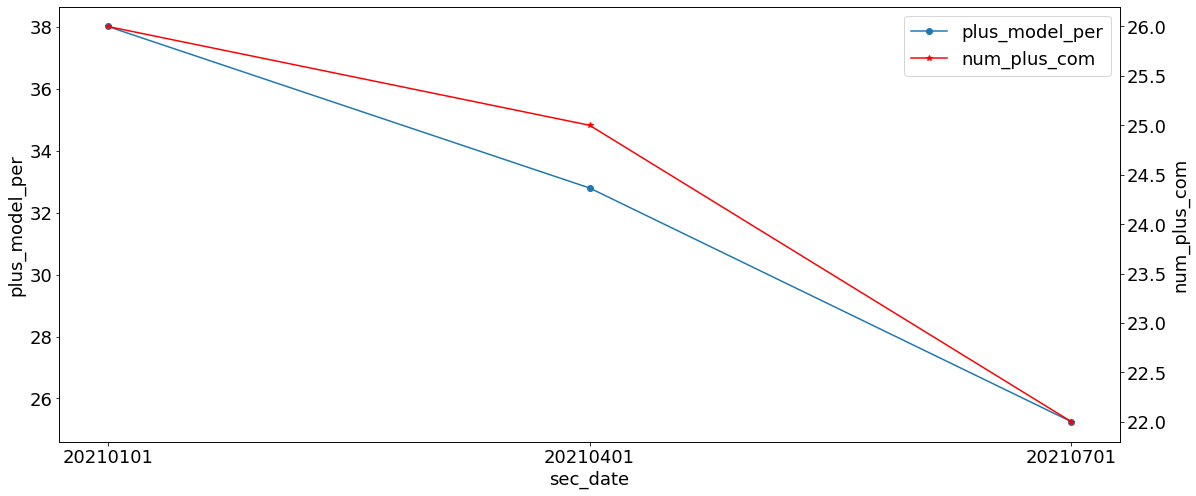

<ipython-input-32-4b8d49003a51>:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


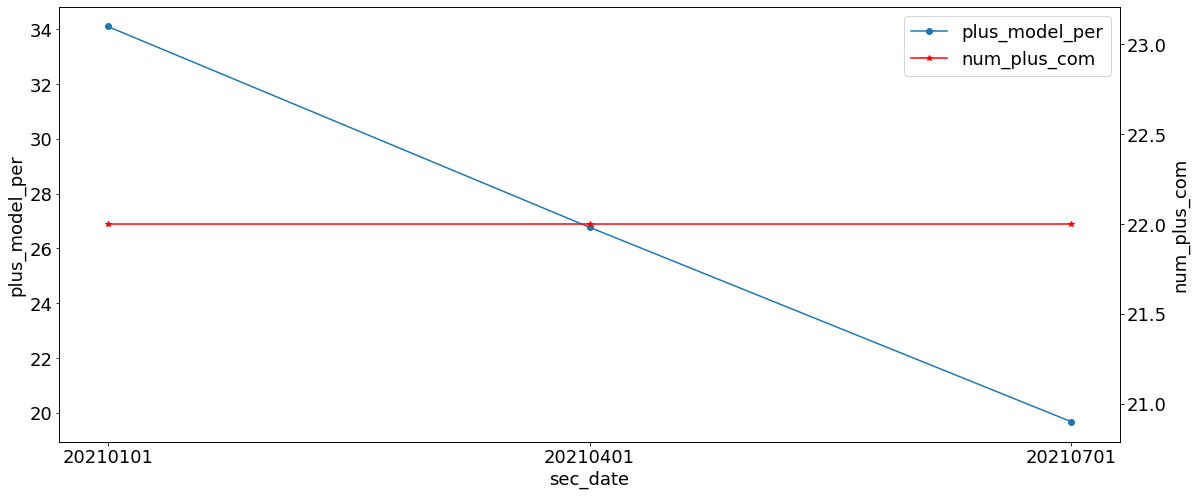

<ipython-input-32-4b8d49003a51>:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


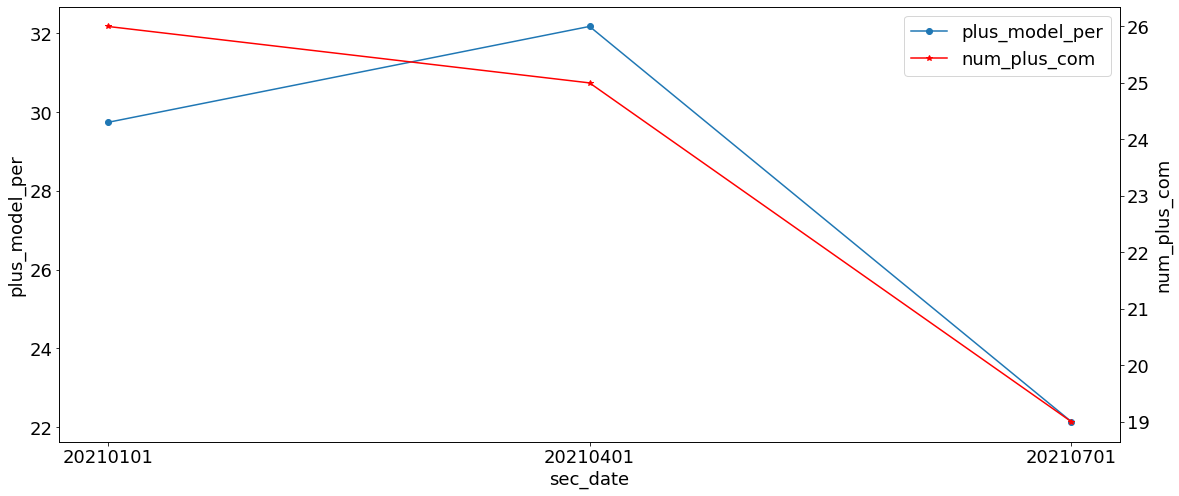

<ipython-input-32-4b8d49003a51>:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


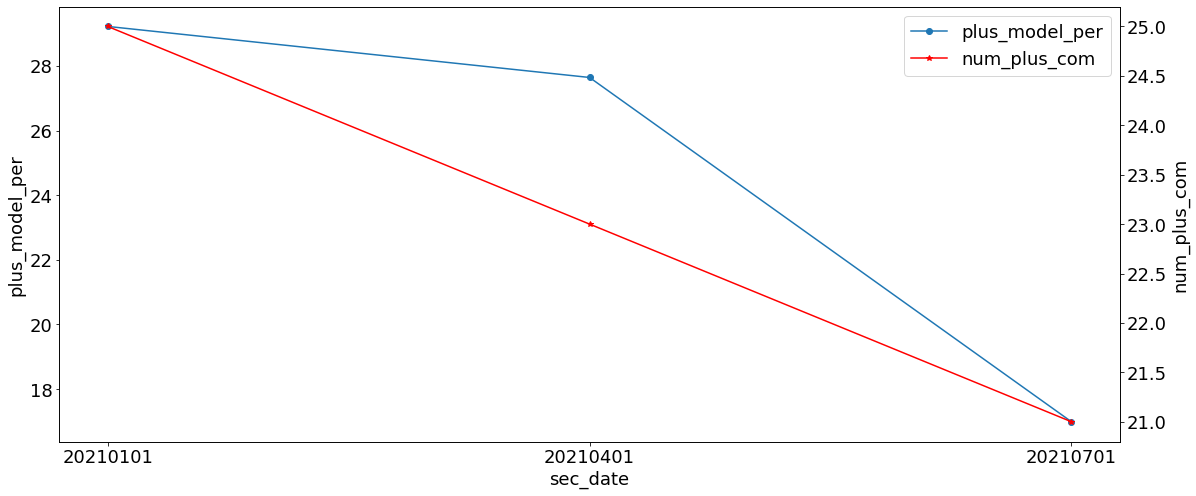

<ipython-input-32-4b8d49003a51>:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


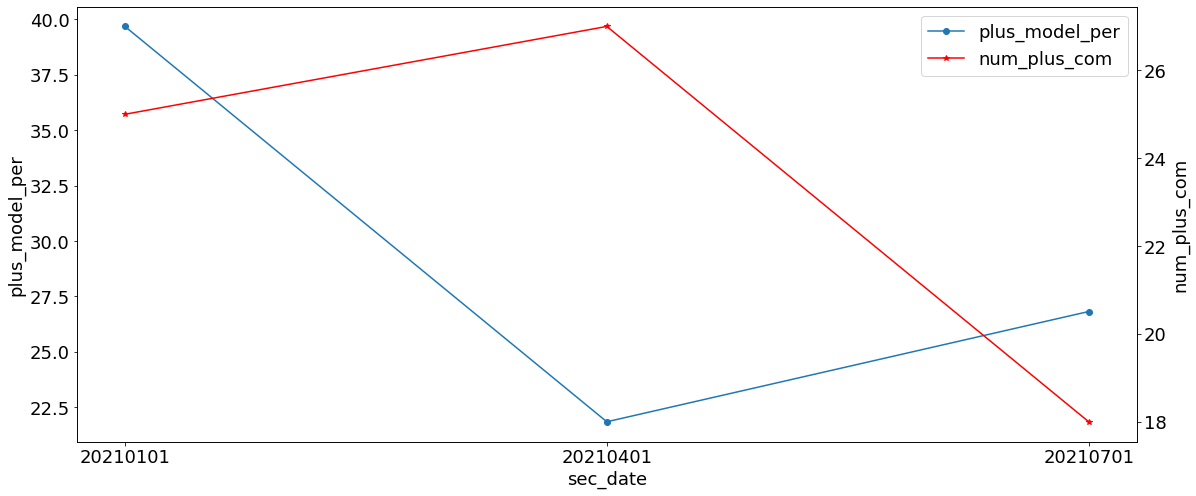

<ipython-input-32-4b8d49003a51>:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


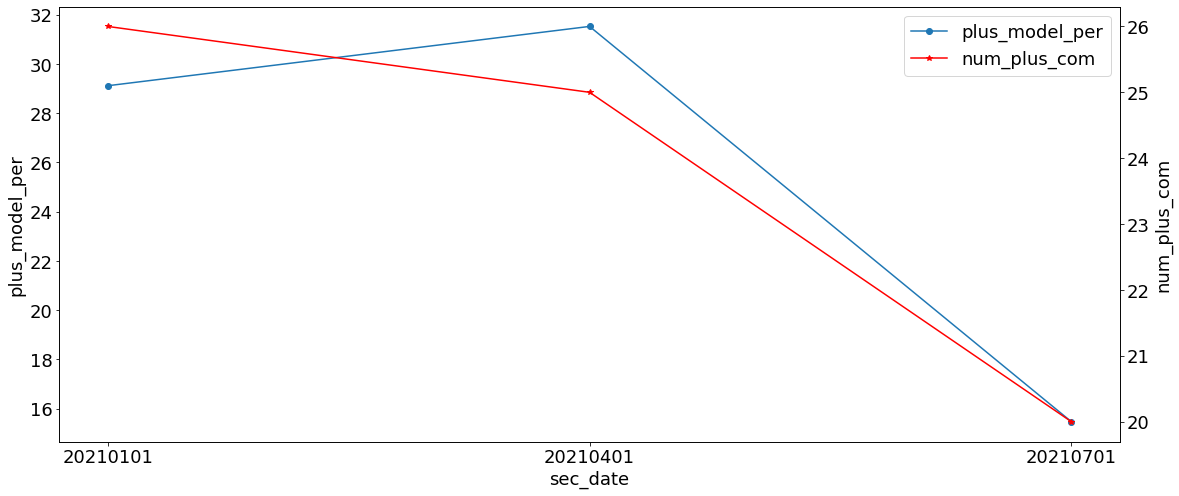

In [34]:
version='V4_2'
mode='model_score_'
mode_type='recent'
for place_name in place_names[:10]:
    analysis_df=pd.DataFrame(columns=['sec_date','num_plus_model','plus_model_per','num_plus_com','plus_com_per'])
    for i in range(3):
        now_ym=datetime.datetime(year=2021, month=1+(i*3),day=1).strftime('%Y%m%d')
        dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{place_name}_{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=now_ym,version=version)
        model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
        model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
        add_s=get_num_plus_model_com(model_score_df)
        add_s['sec_date']=now_ym
        analysis_df=analysis_df.append(add_s,ignore_index=True)
        
    x_n='sec_date'
    y1_n='plus_model_per'
    y2_n='num_plus_com'
    df_twin_plt(analysis_df,x_n,y1_n,y2_n)
plt.close()

### period

<ipython-input-32-4b8d49003a51>:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


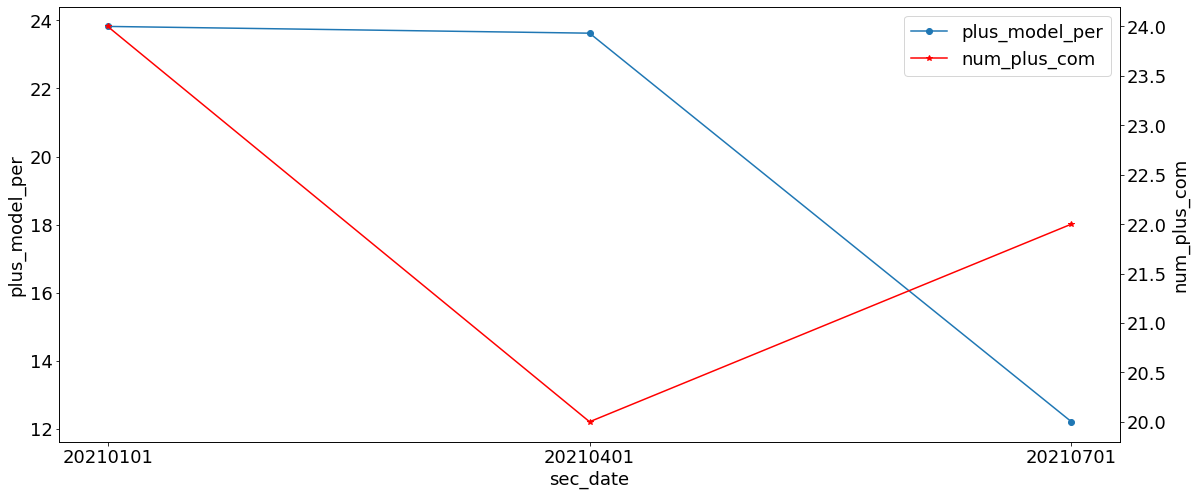

<ipython-input-32-4b8d49003a51>:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


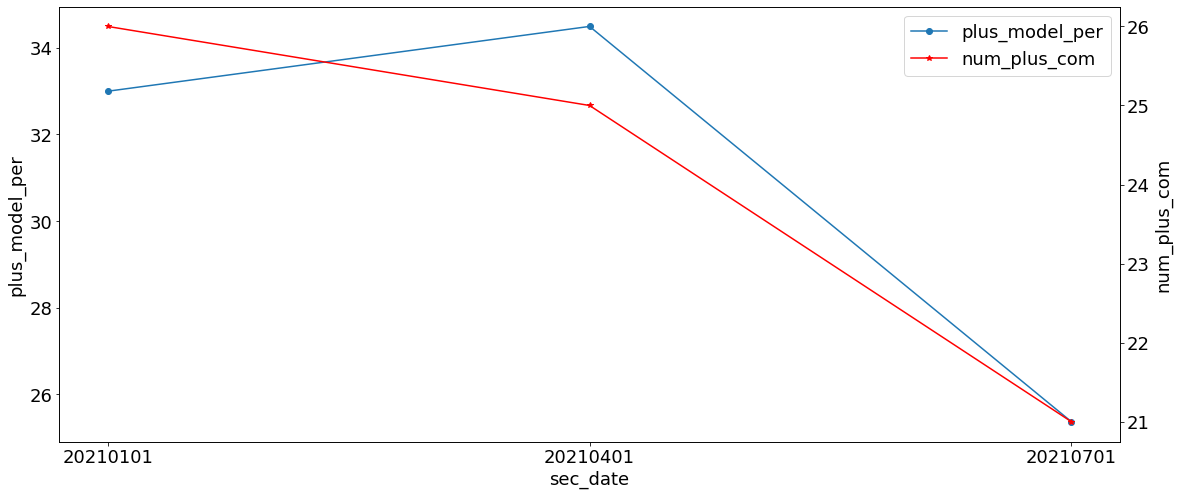

<ipython-input-32-4b8d49003a51>:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


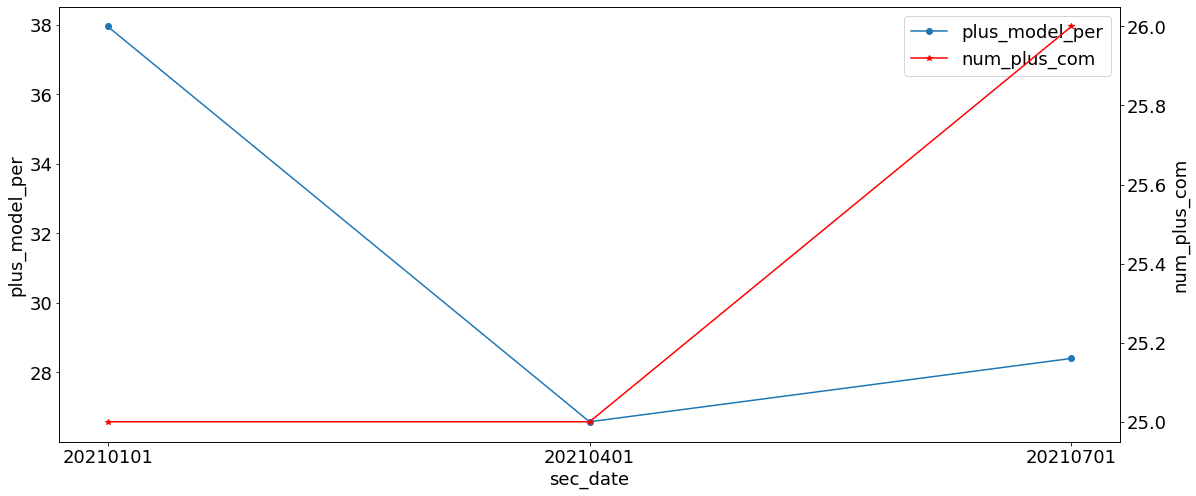

<ipython-input-32-4b8d49003a51>:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


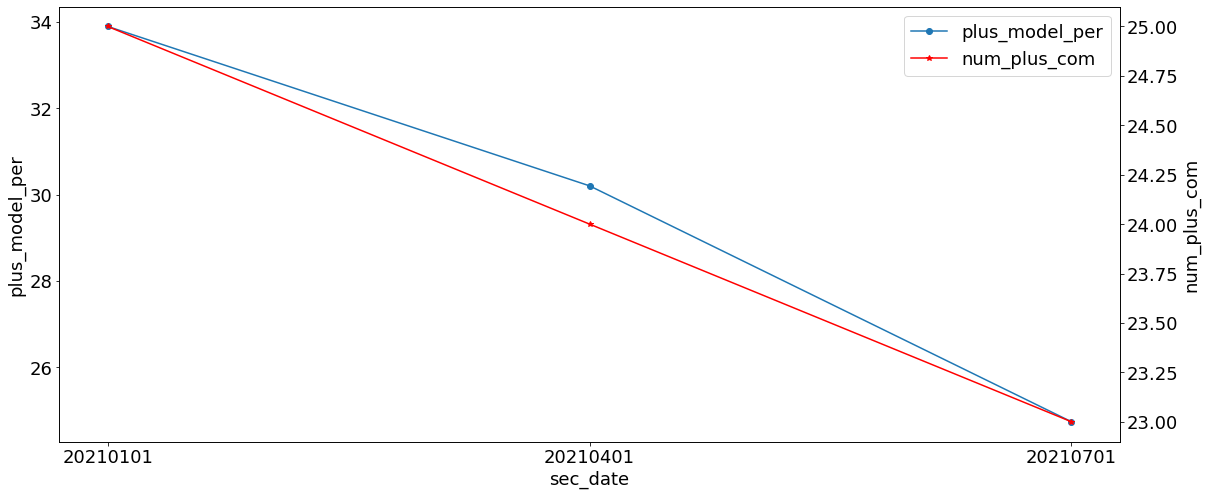

<ipython-input-32-4b8d49003a51>:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


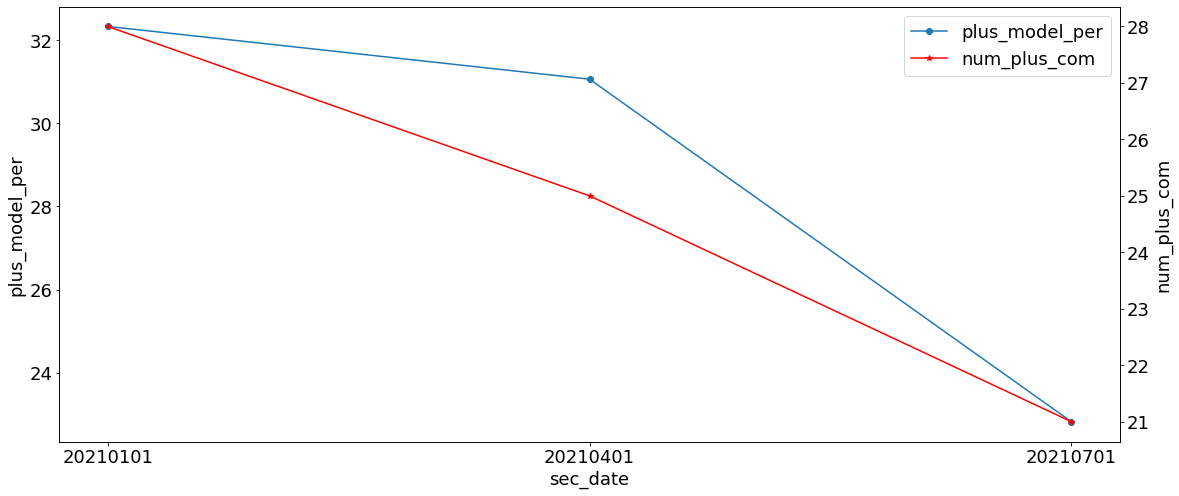

<ipython-input-32-4b8d49003a51>:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


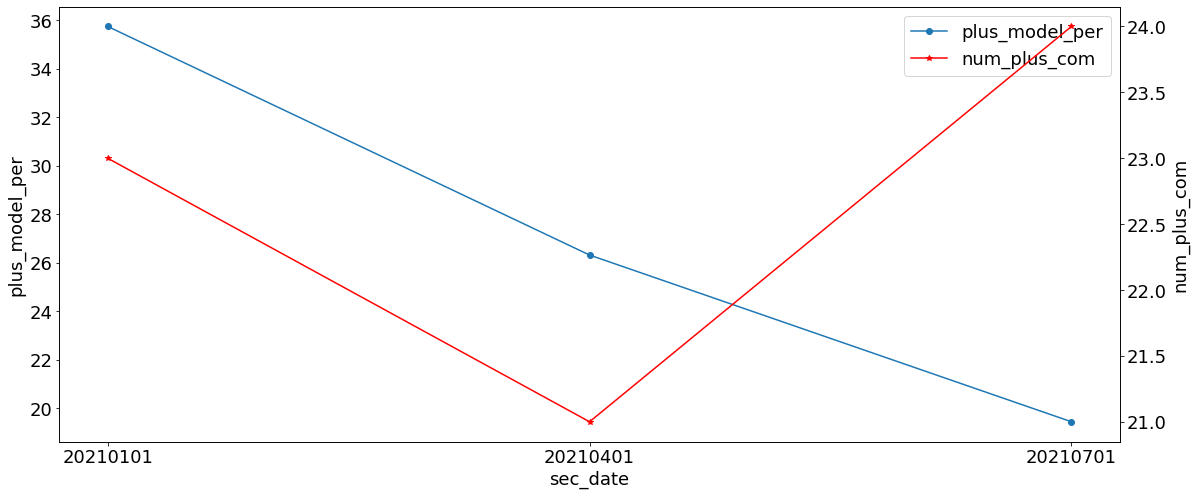

<ipython-input-32-4b8d49003a51>:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


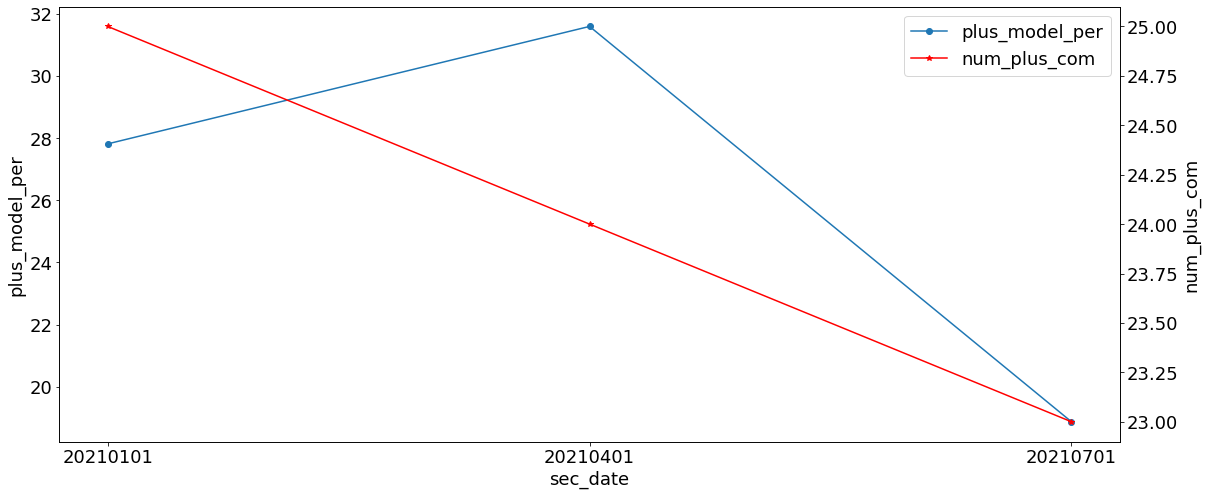

<ipython-input-32-4b8d49003a51>:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


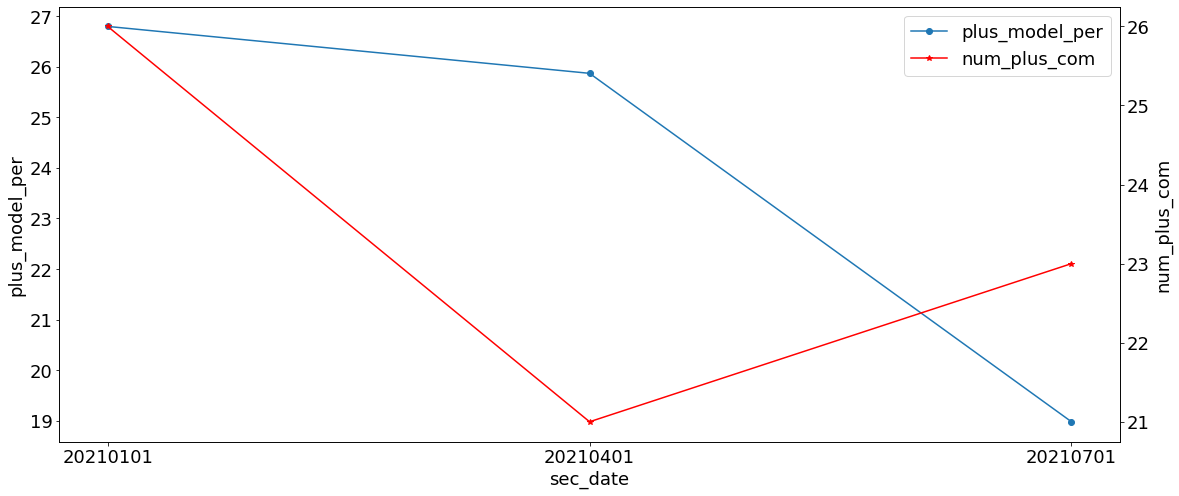

<ipython-input-32-4b8d49003a51>:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


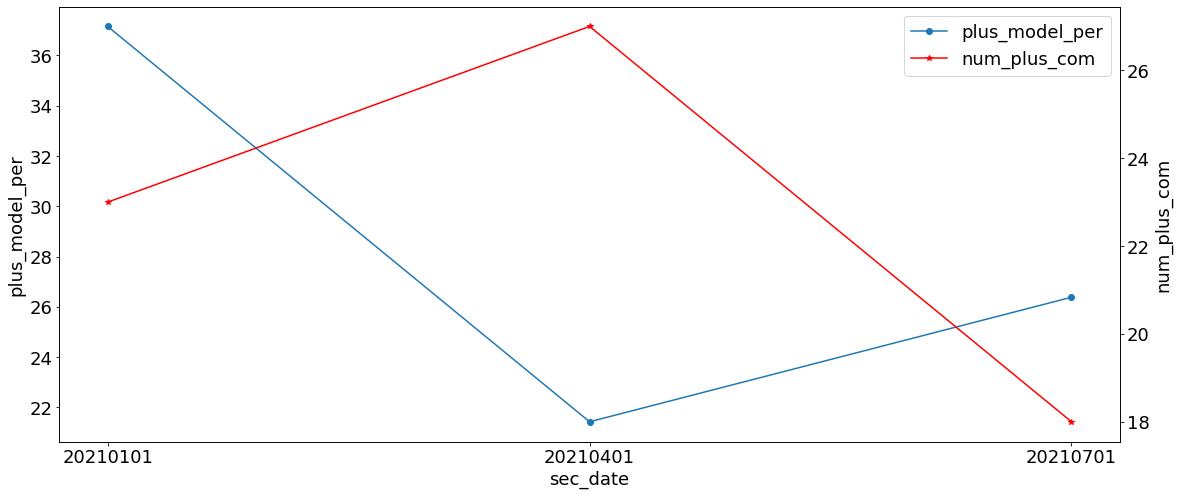

<ipython-input-32-4b8d49003a51>:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


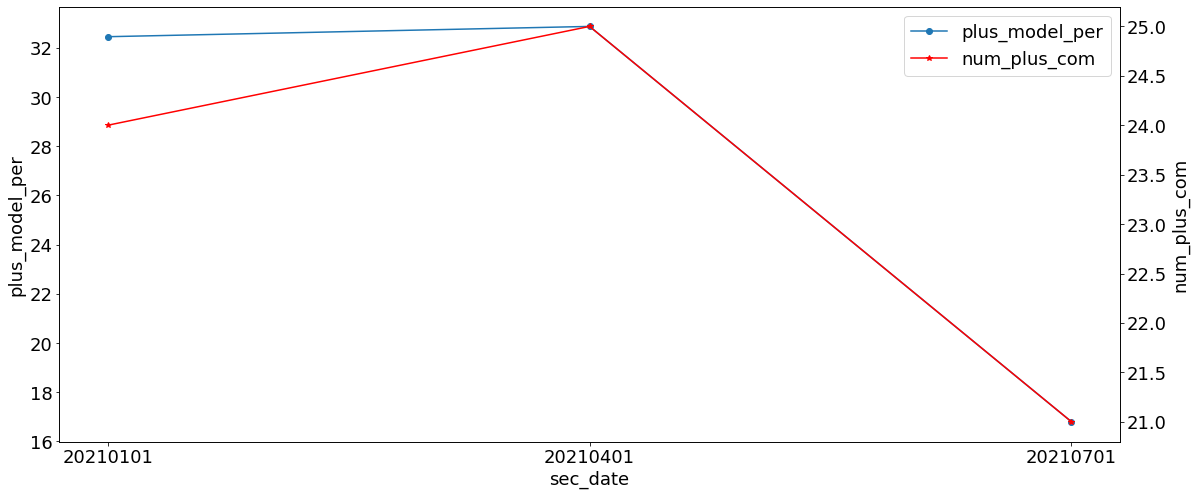

In [35]:
version='V4_2'
mode='model_score_period_'
mode_type='period'
for place_name in place_names[:10]:
    analysis_df=pd.DataFrame(columns=['sec_date','num_plus_model','plus_model_per','num_plus_com','plus_com_per'])
    for i in range(3):
        now_ym=datetime.datetime(year=2021, month=1+(i*3),day=1).strftime('%Y%m%d')
        dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{place_name}_{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=now_ym,version=version)
        model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
        model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
        add_s=get_num_plus_model_com(model_score_df)
        add_s['sec_date']=now_ym
        analysis_df=analysis_df.append(add_s,ignore_index=True)
        
    x_n='sec_date'
    y1_n='plus_model_per'
    y2_n='num_plus_com'
    df_twin_plt(analysis_df,x_n,y1_n,y2_n)
plt.close()

# 各スコアシートの変数の分布をみる(標準化の際に，各々特別な処置が必要そうなのかどうか判断したい)
=それぞれの区間のシートで見てみる，数が多いのでいくつかの会場をピックしてみてみる

In [36]:
# version='V4_2'
# mode='model_score_period_'
# mode_type='period'
# for place_name in place_names[:3]:
#     analysis_df=pd.DataFrame(columns=['sec_date','num_plus_model','plus_model_per','num_plus_com','plus_com_per'])
#     print(place_name,'=============================================================================')
#     for i in range(3):
#         now_ym=datetime.datetime(year=2021, month=1+(i*3),day=1).strftime('%Y%m%d')
#         print(now_ym,'=============================================================================')
#         dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{place_name}_{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=now_ym,version=version)
#         model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
#         model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
        
#         test_score_df=model_score_df.loc[:,'total_get_test':'diff_mea_med_test'].copy()#相関係数を代用した変数ごとの重みづけ
#         test_score_df=test_score_df.drop(["num_com_test"],axis=1)

#         for col in test_score_df.columns:
#             if col=='gain_test':
#                 df_hist_plt(test_score_df,col)
#              #df_hist_plt(test_score_df,col)
# plt.close()

### 標準化すると分布がどうなるのか確認

In [37]:
# version='V4_2'
# mode='model_score_period_'
# mode_type='period'
# for place_name in place_names[:3]:
#     analysis_df=pd.DataFrame(columns=['sec_date','num_plus_model','plus_model_per','num_plus_com','plus_com_per'])
#     print(place_name,'=============================================================================')
#     for i in range(3):
#         now_ym=datetime.datetime(year=2021, month=1+(i*3),day=1).strftime('%Y%m%d')
#         print(now_ym,'=============================================================================')
#         dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{place_name}_{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=now_ym,version=version)
#         model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
#         model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
        
#         test_score_df=model_score_df.loc[:,'total_get_test':'diff_mea_med_test'].copy()#相関係数を代用した変数ごとの重みづけ
#         test_score_df=test_score_df.drop(["num_com_test"],axis=1)
#         test_score_df=test_score_df.fillna(0)
#         for col in test_score_df.columns:
#             test_score_df[col]=scipy.stats.zscore(test_score_df[col].values)
#         for col in test_score_df.columns:
#             if col=='gain_test':
#                 df_hist_plt(test_score_df,col)
#             #df_hist_plt(test_score_df,col)
# plt.close()

### ↑の結果について
やっぱりかなりの変数が正規分布していなかった，左端が多く，右に向かって下がっていく．このことと～やることも決まった<br>
・標準化の調査のためにも，これを標準化してヒストグラムを作成する＝全然正規化できてなかった，スケールが変わっただけグラフの概形は全く変わっていない<br>
・ダメだった場合，これの正規化，もし桑この対数の場合にどんな統計指標が用いられるかを調べるor考える
    

# period recent関連の分析

# center関連の分析

## centerでの基礎集計
去年のtest,finalの両方でプラス，かつ今年でも両方ともプラスの[model,com]の数と割合を算出

### とりあえずシート単位

In [38]:
# version='V4_2'
# mode='model_score_period_'
# mode_type='period'
# for place_name in place_names[:5]:
#     analysis_df=pd.DataFrame(columns=['sec_date','num_plus_model','plus_model_per','num_plus_com','plus_com_per'])
#     for i in range(3):
#         now_ym=datetime.datetime(year=2021, month=1+(i*3),day=1).strftime('%Y%m%d')
#         dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{place_name}_{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=now_ym,version=version)
#         model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
#         model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
        
#         both_gain_df=model_score_df[(model_score_df['gain_test']>=105)&(model_score_df['gain_final']>=105)]
#         add_s=get_num_plus_model_com(both_gain_df)
#         add_s['sec_date']=now_ym
#         analysis_df=analysis_df.append(add_s,ignore_index=True)
        
#     x_n='sec_date'
#     y1_n='plus_model_per'
#     y2_n='num_plus_com'
#     df_twin_plt(analysis_df,x_n,y1_n,y2_n)
# plt.close()

## center関連での，可能性調査（切り落としたステップごとの，収益モデル，comの割合）
### 基本的な処理はモデル選定コード(model_analysis_V4_2_periodのものをコピペしてある)

kiryu ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


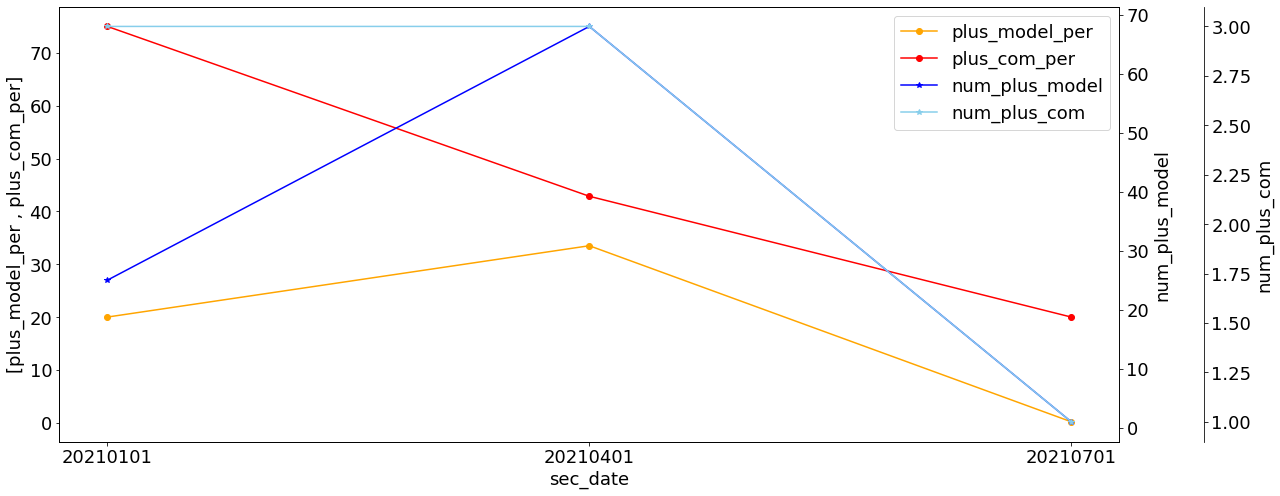

toda ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


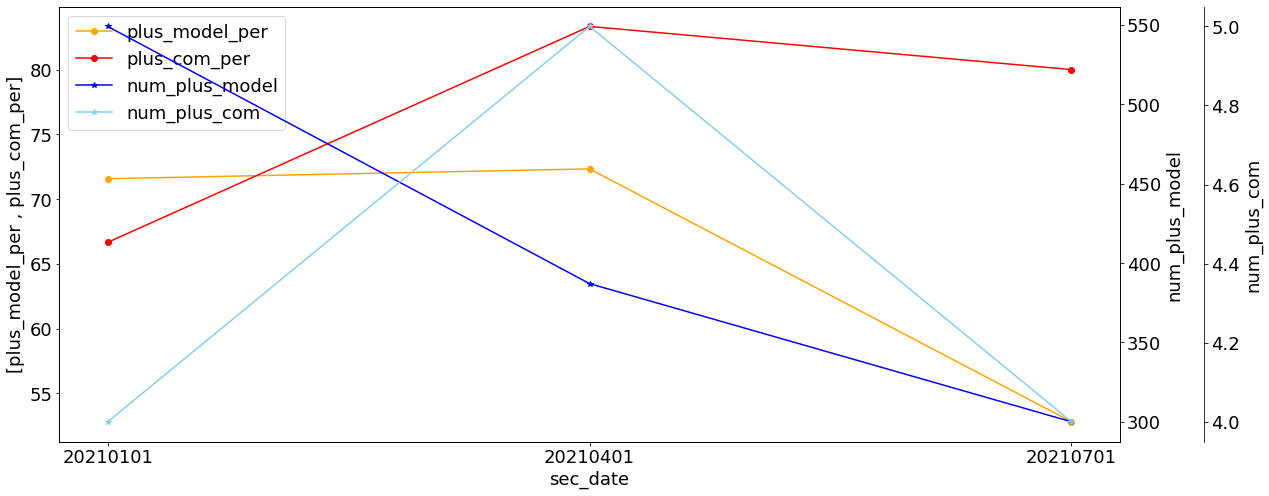

edogawa ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


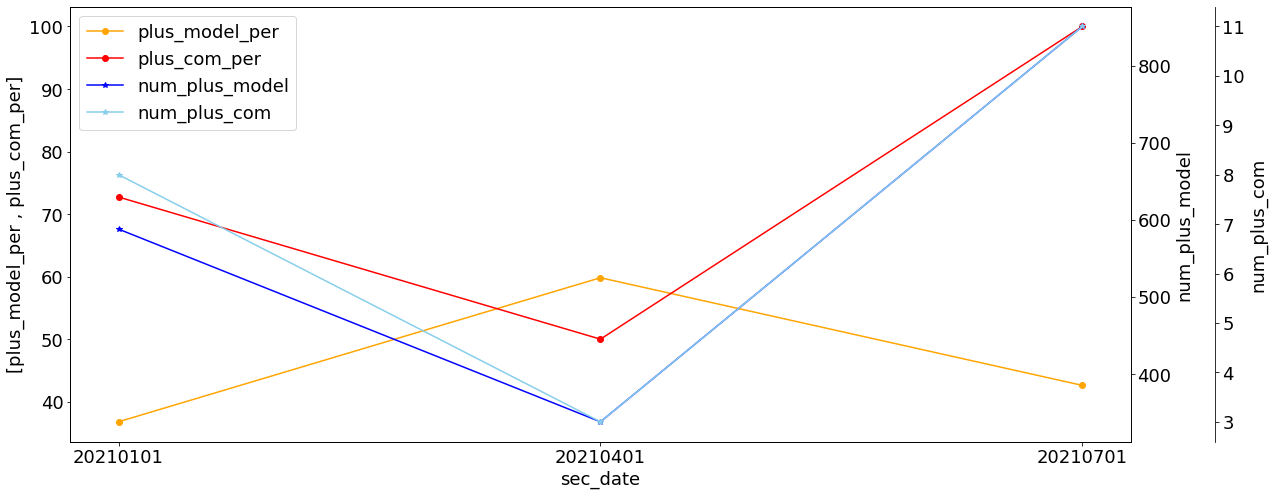

heiwazima ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


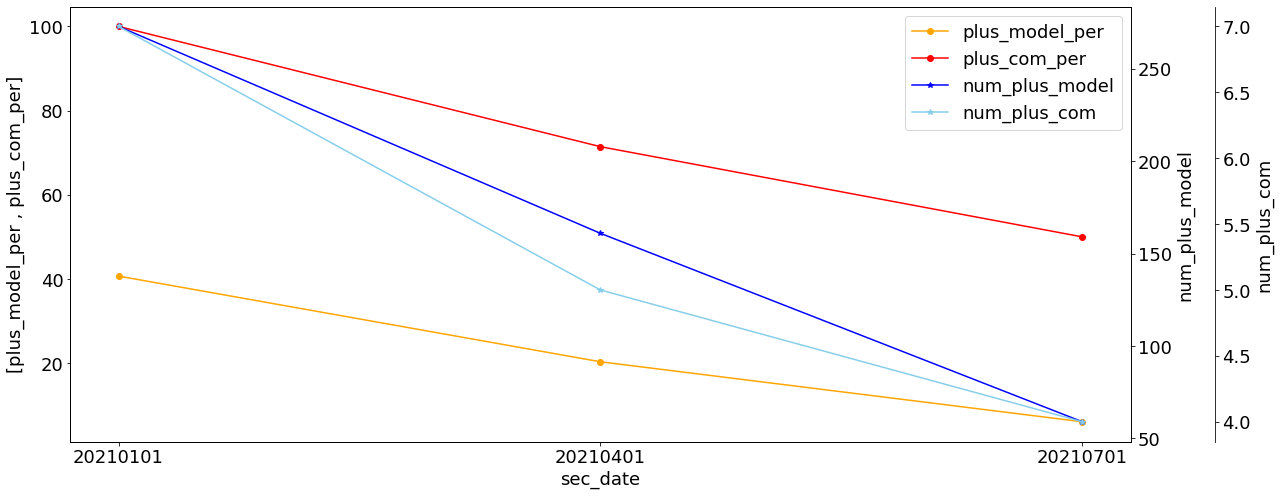

tamagawa ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


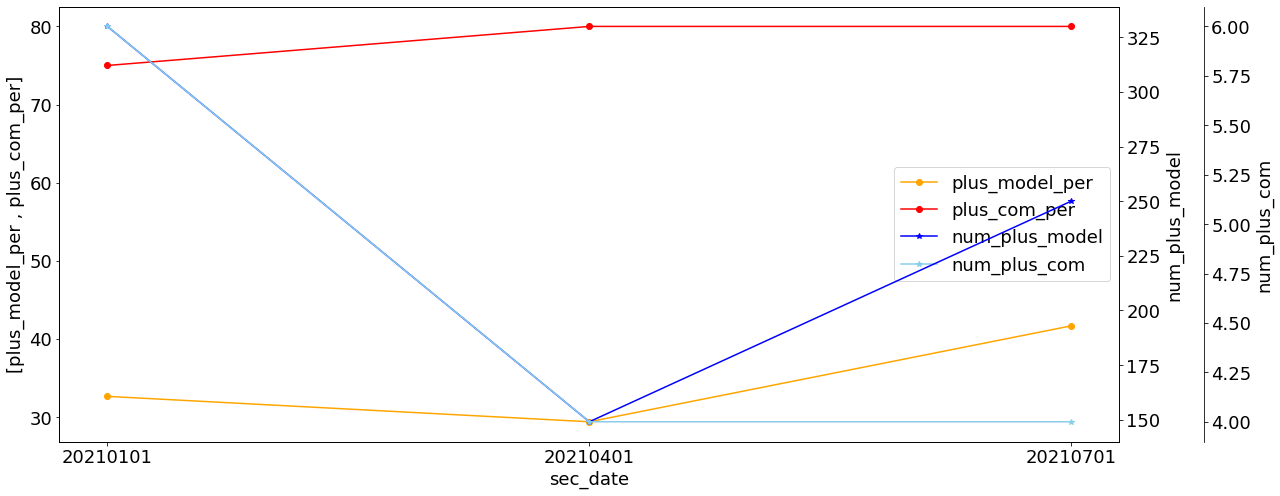

hamanako ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


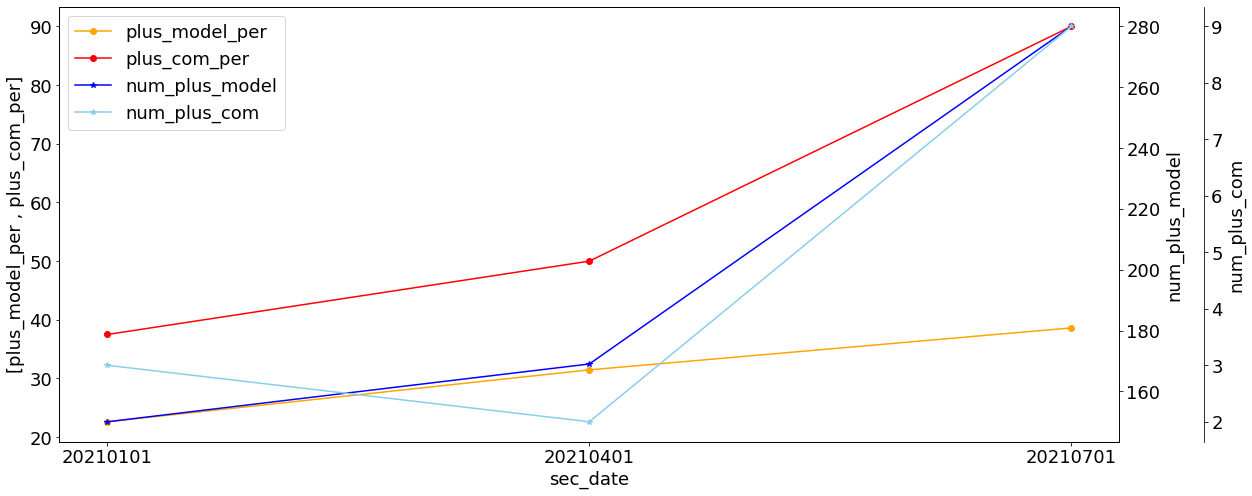

gamagori ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


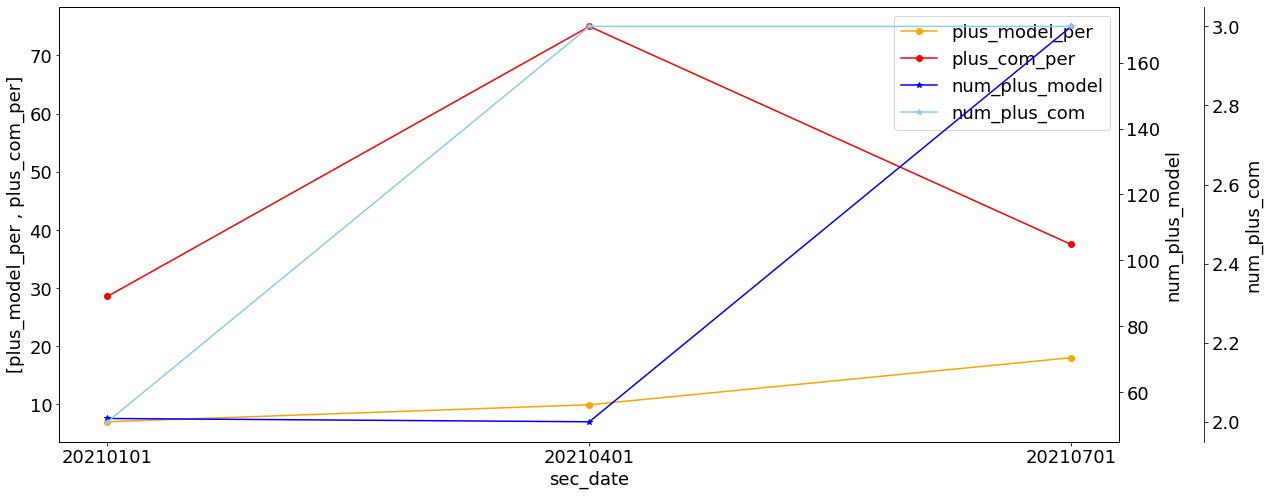

tokoname ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


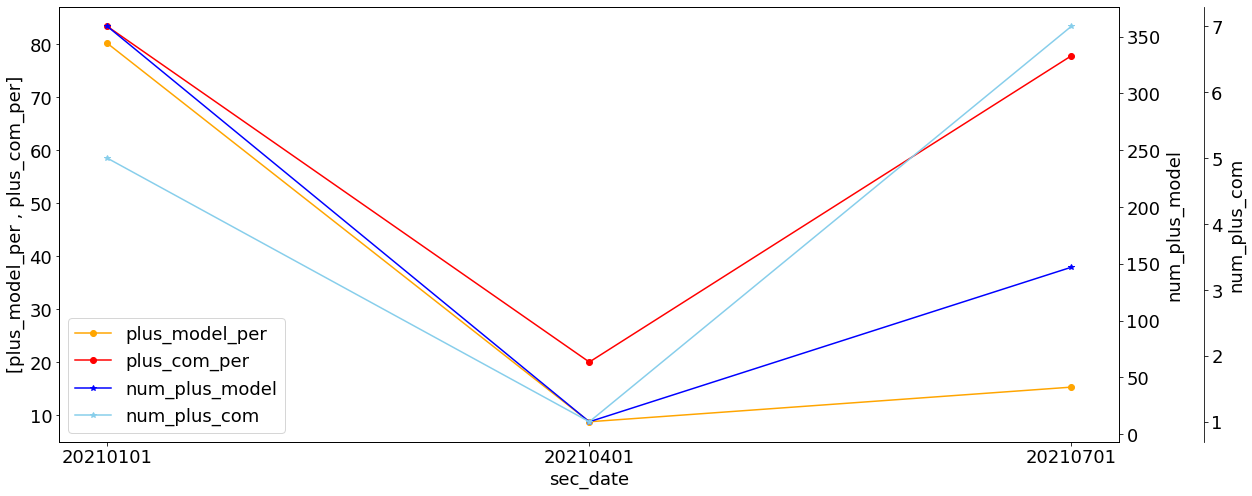

tu ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


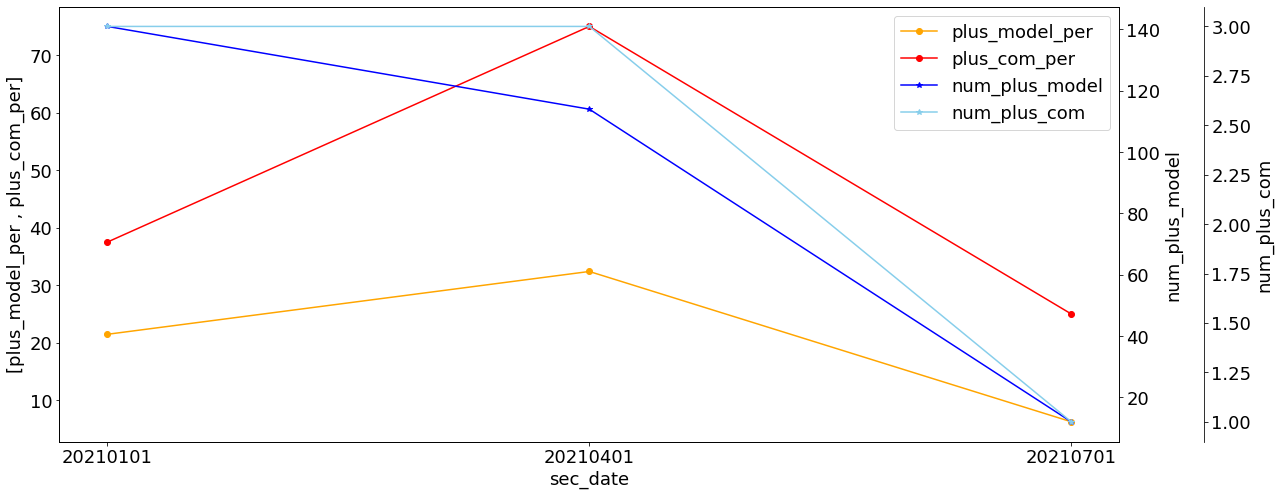

mikuni ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


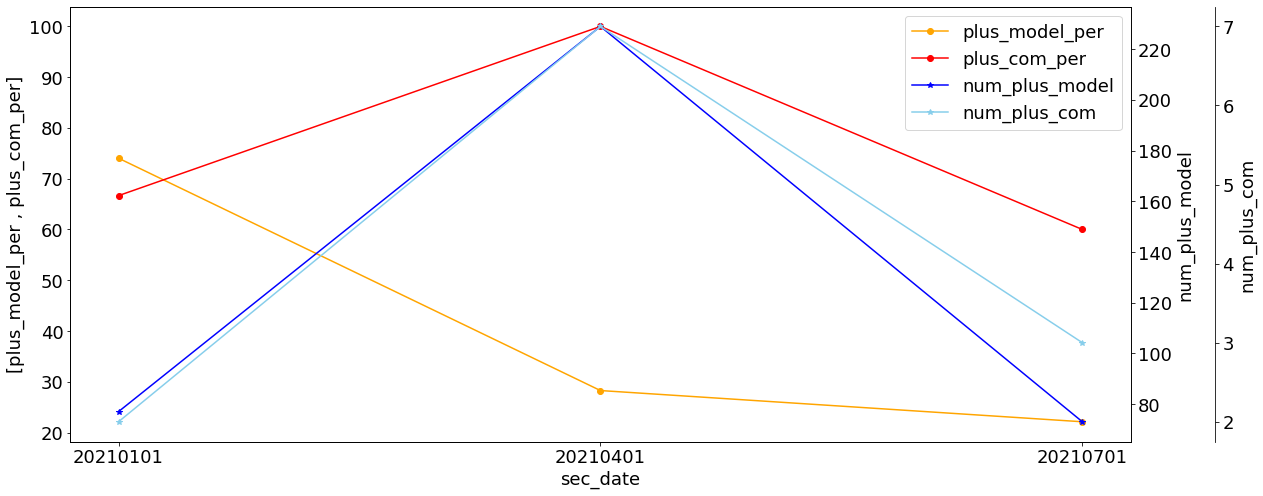

biwako ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


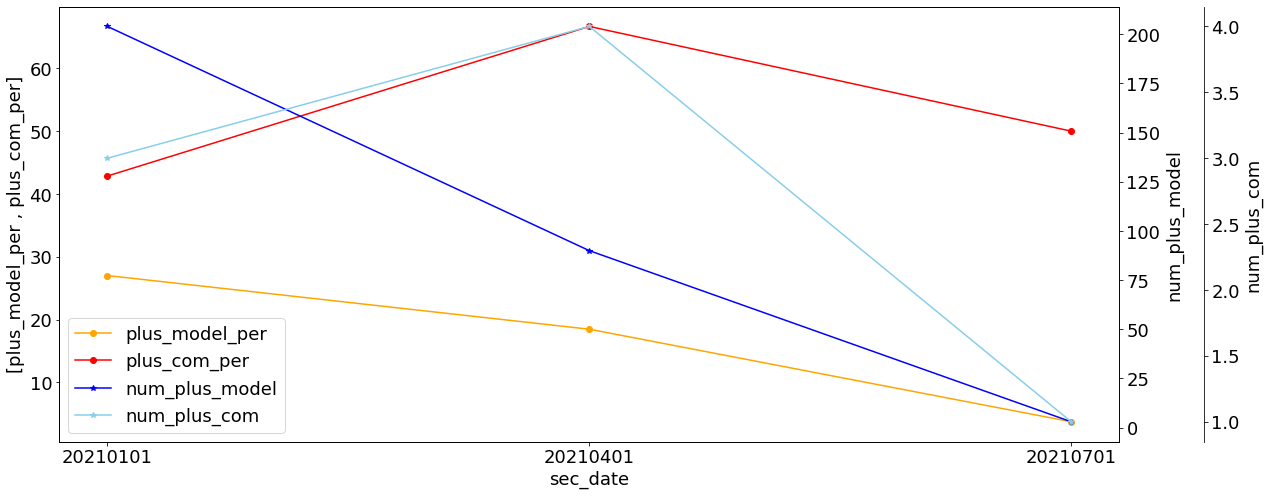

suminoe ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


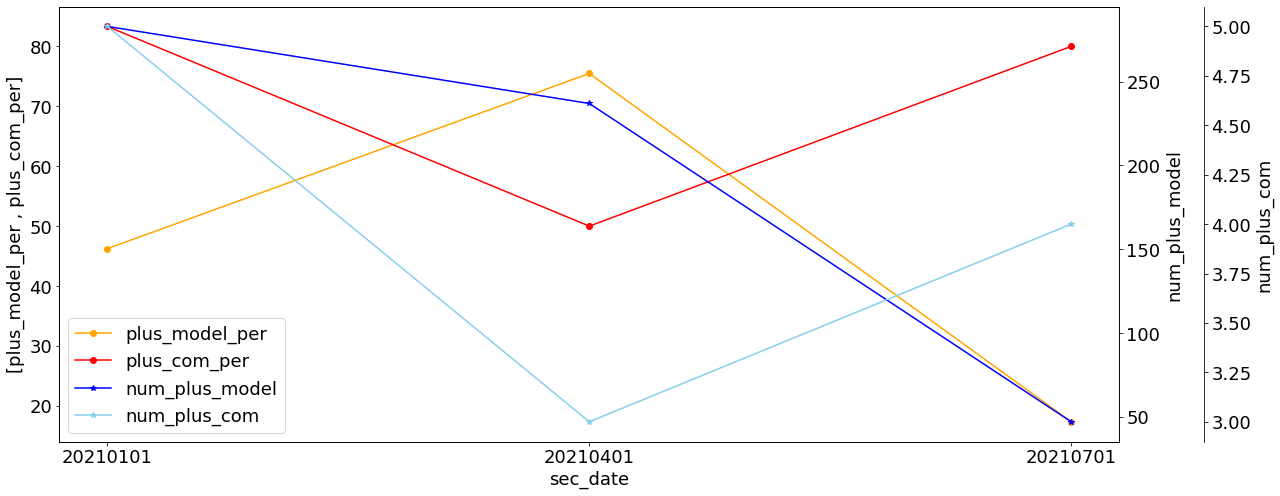

amagasaki ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


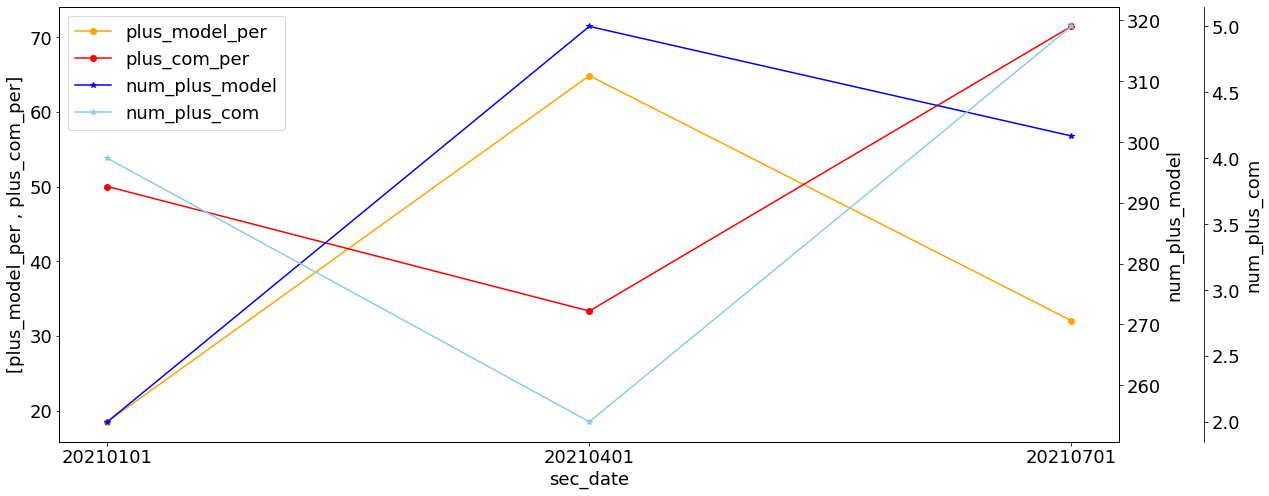

naruto ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


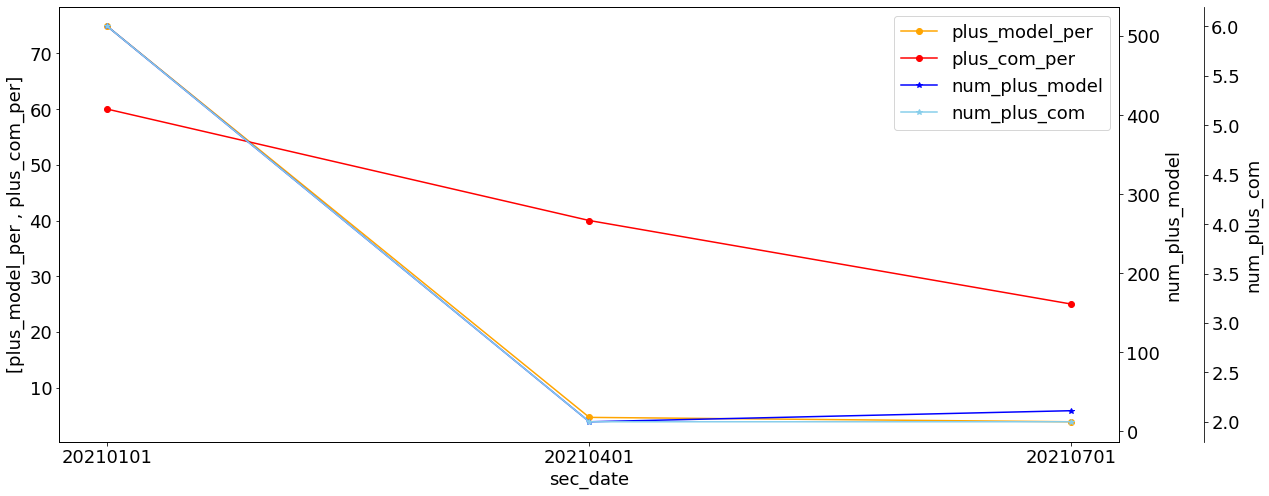

marugame ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


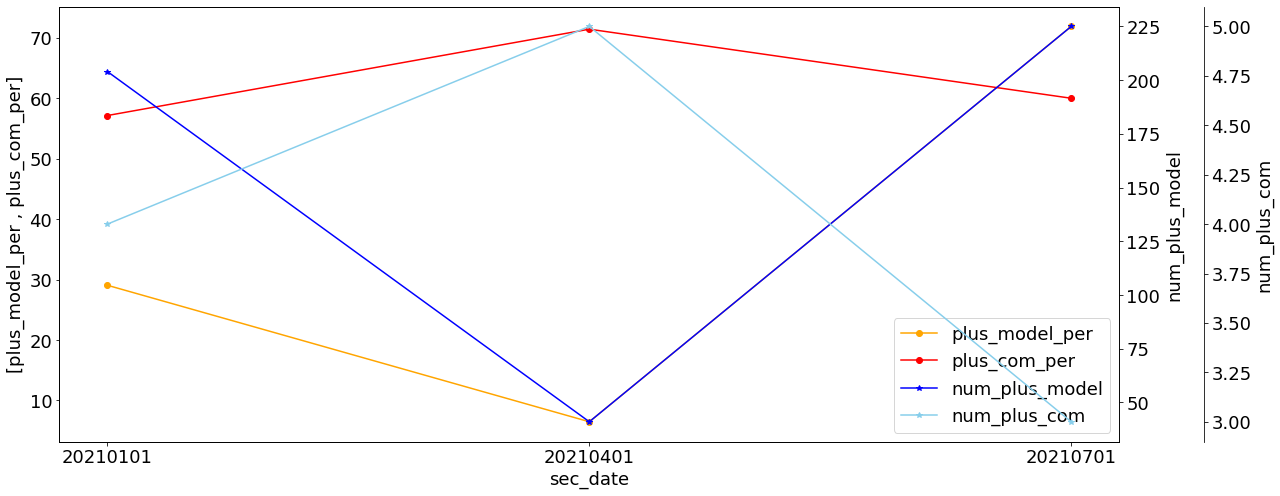

kozima ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


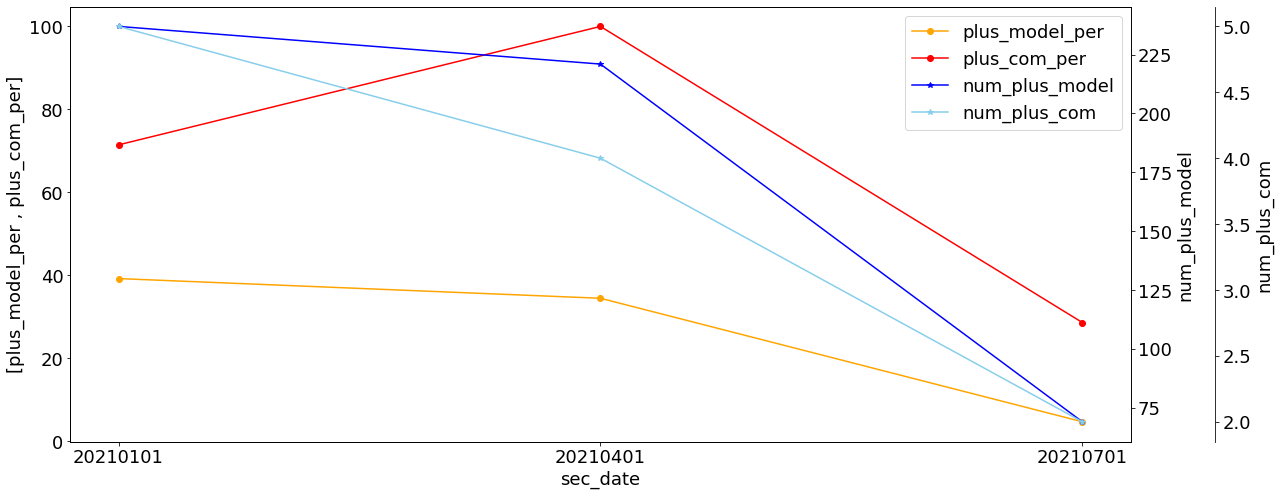

miyazima ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


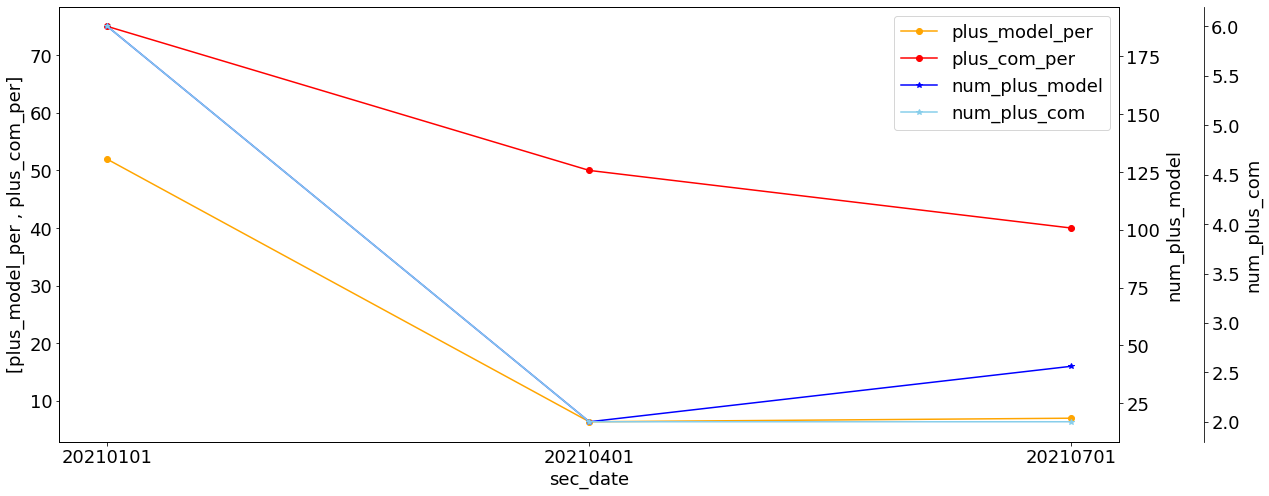

tokuyama ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


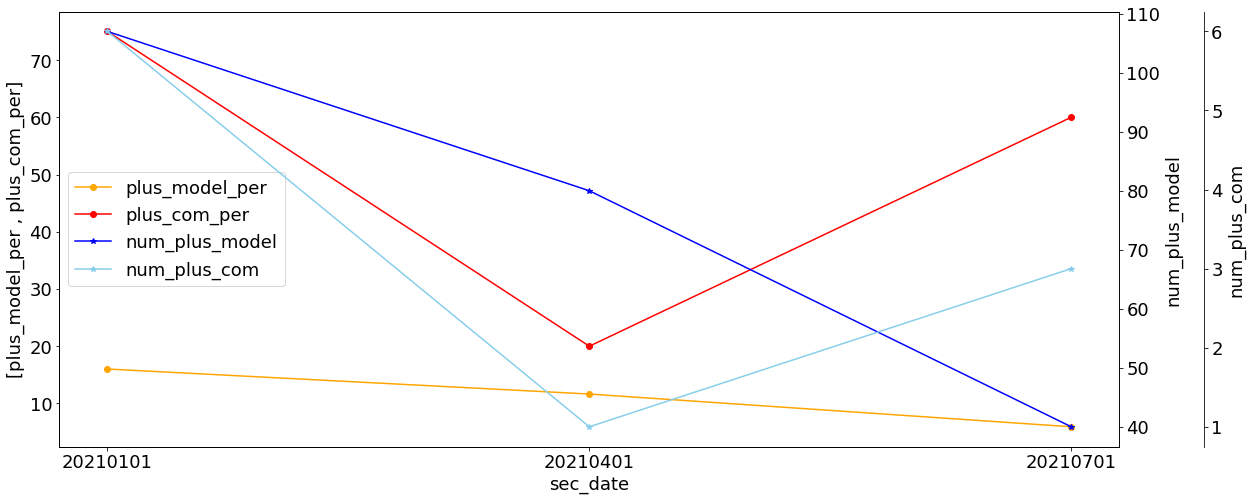

simonoseki ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


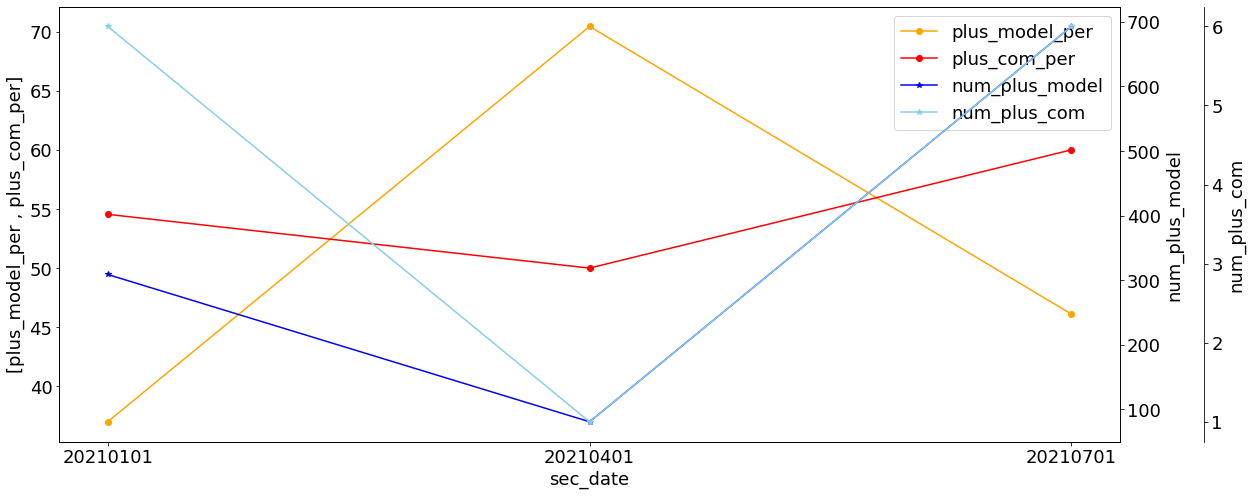

wakamatu ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


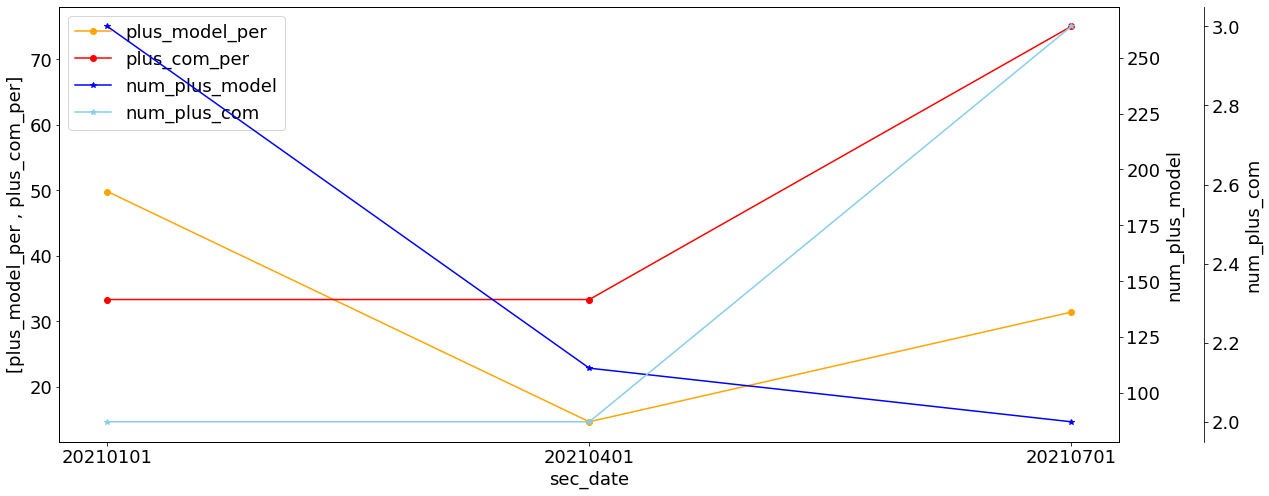

asiya ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


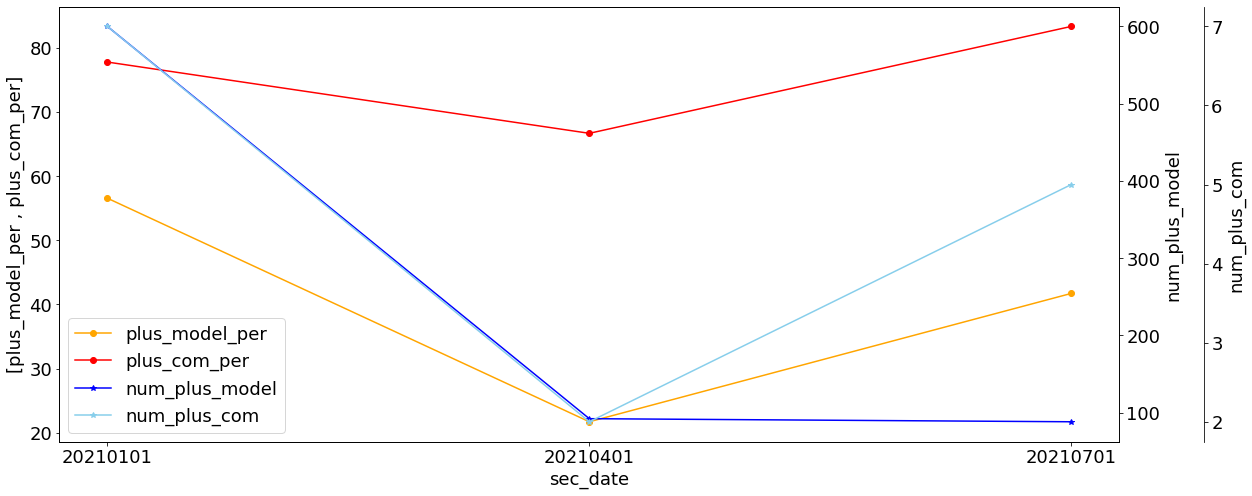

fukuoka ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


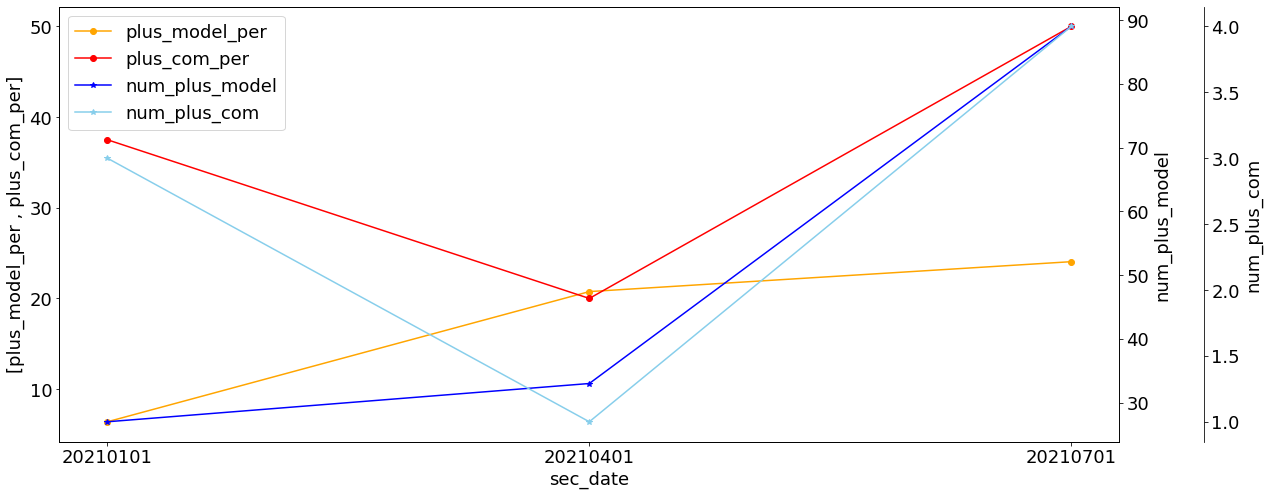

karatu ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


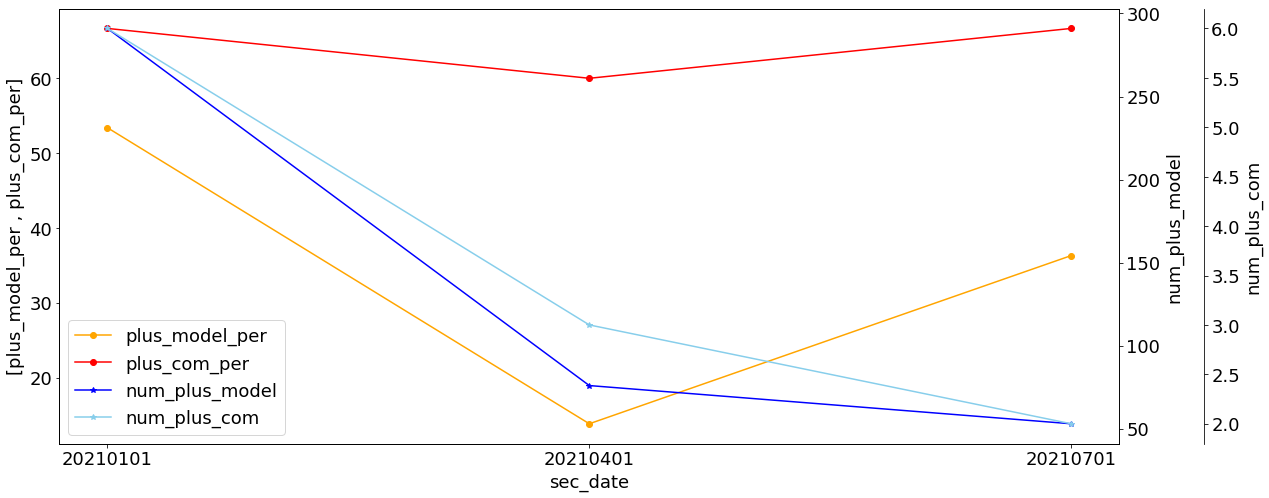

omura ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


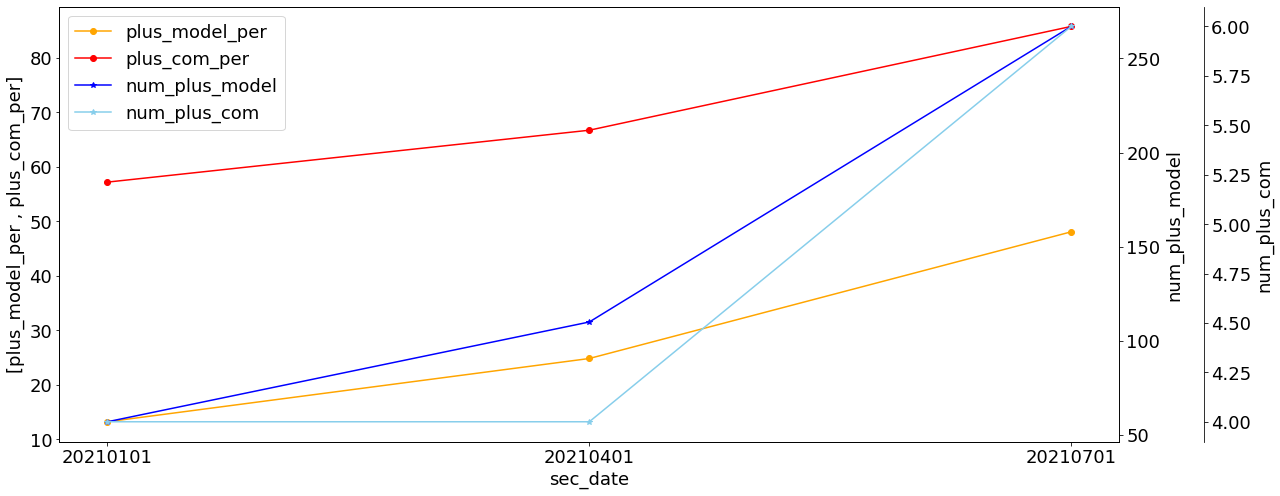

In [47]:
place_master=master.get_place_master()
place_names=[place_name for place_name in place_master.values()]#会場名のみを収納した配列
#絶対に固定のパラメータたち
plus_m_th=1

num_hit_th=3
version='V4_2'
mode='model_score_period_'
mode_type='period'
#today=datetime.date.today()#今日の日付の取得
today=datetime.datetime(year=2021, month=10,day=1)
now_date=today
for place_name in place_names:
    #place_name='heiwazima'
    print(place_name,'===============================================================')
    analysis_df=pd.DataFrame(columns=['sec_date','num_plus_model','plus_model_per','num_plus_com','plus_com_per'])

    #     diff_sec_dates=get_4_section_dt(now_date)#直近４区間の開始日をリストで取得
    #     now_date_txt=now_date.strftime('%Y%m%d')
    #     diff_sec_dates=diff_sec_dates[1:]#テスト時のみの特別処理！！データが１区間だけ足りないので今回はスルーする
    #閾値にあてはまった　モデルたちがどんな奴らなのかを確認する
    for i in range(3):
        #i=0
        sec_date=datetime.datetime(year=2021, month=1+(i*3),day=1)
        sec_date_txt=sec_date.strftime('%Y%m%d')

        #昨年同月のfinalあり分析結果のシートから使えそうなcom，集団を作成し，パラメータが参照できるように切り抜く
        date_cal_last=sec_date- relativedelta(months=12)#昨年同月の区間の日付を切り抜く
        date_cal_last_txt=date_cal_last.strftime('%Y%m%d')
        dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{place_name}_{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=date_cal_last_txt,version=version)
        model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
        model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
        #今年のスコアシートと，昨年同月から選んだモデルたちを渡して，今年で使うモデルを切り抜く
        dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{place_name}_{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=sec_date_txt,version=version)
        now_model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')#今年のスコアシートの読み込み
        now_model_score_df=now_model_score_df.drop(["Unnamed: 0"],axis=1)
        #並べる順番を変える，閾値をはじめの方に持ってきた
        model_score_df=model_score_df.sort_values(['target_com', 'threshold','depth','target_per'])
        model_score_df = model_score_df.reset_index(drop=True)
        #print('before_drop[num_com]:',len(model_score_df))#収益で切り落とす前のモデル数
        both_plus_models=model_score_df[(model_score_df['gain_test']>100)&(model_score_df['gain_final']>100)].copy()#まずは昨年同月の，testとfinalともに利益が出ていたものを切り抜く
        #print('after_drop[num_com]:',len(both_plus_models))#収益で切り落とした後のモデル数
        models_has_g_num_df=serch_group(both_plus_models)#モデルのパラメータから集団番号を付与


        #試しに決めの値で集団長を指定して切り抜く（どの程度利益の出ているモデル,comがあるのか）
        len_th=10
        g_num_len=models_has_g_num_df['group_num'].value_counts()#集団番号ごとの長さ
        numbers_g_s=g_num_len.loc[g_num_len>=len_th]#集団の長さが閾値以上のものをvalue_counts()の結果から切り抜く
        group_df=pd.DataFrame()
        for g_num in numbers_g_s.index:
            target_g_num_df=models_has_g_num_df[models_has_g_num_df['group_num']==g_num]
            group_df=pd.concat([group_df,target_g_num_df])

        #可能性分析
        same_param_models_df=get_same_para_model(group_df,now_model_score_df)
        add_s=get_num_plus_model_com(same_param_models_df)
        add_s['sec_date']=sec_date_txt
        analysis_df=analysis_df.append(add_s,ignore_index=True)
    x_n='sec_date'
    y1_1_n='plus_model_per'
    y1_2_n='plus_com_per'
    y2_1_n='num_plus_model'
    y2_2_n='num_plus_com'
    df_triple_plt(analysis_df,x_n,y1_1_n,y1_2_n,y2_1_n,y2_2_n)
    plt.close()
        #display(analysis_df)
    #         print('last_year===========================================================================================')
    #         display(group_df)

    #         print('now_year===========================================================================================')
    #         display(same_param_models_df)





    #         #集団の真ん中のモデルを切り抜く
    #         g_nums_counts=group_df['group_num'].value_counts(sort=False)
    #         center_models_df=pd.DataFrame(columns=group_df.columns)#真ん中で切り抜いたモデルのか格納先
    #         for index,len_group in g_nums_counts.items():
    #             model_groups_df=group_df[group_df['group_num']==index].copy()
    #             target_row=model_groups_df.iloc[int(len_group)-1]
    #             center_models_df=center_models_df.append(target_row)

    #         #絶対的な的中数でさらにモデルを切り抜く
    #         hit_th=5
    #         good_models_df=center_models_df[(center_models_df['num_hit_test']>hit_th) & (center_models_df['num_hit_final']>hit_th)].copy()
    #         #good_models_df=center_models_df[(center_models_df['num_hit_test']>2) & (center_models_df['num_hit_final']>2)].copy()
    #         selected_models_df=pd.DataFrame(columns=group_df.columns)#真ん中で切り抜いたモデルのか格納先
    #         for com in good_models_df['target_com'].value_counts().index:
    #             good_models_com_df=good_models_df[good_models_df['target_com']==com].copy()
    #             good_models_com_row=good_models_com_df.sort_values(['num_hit_final','gain_final'],ascending=[False, False]).iloc[0]#的中数，finalゲインでsp－として一番大きいものにする
    #             selected_models_df=selected_models_df.append(good_models_com_row)




            #display(use_models_df['gain_final'])
    #same_param_models_df.to_csv('ex.csv')



In [ ]:
analysis_df

kiryu ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


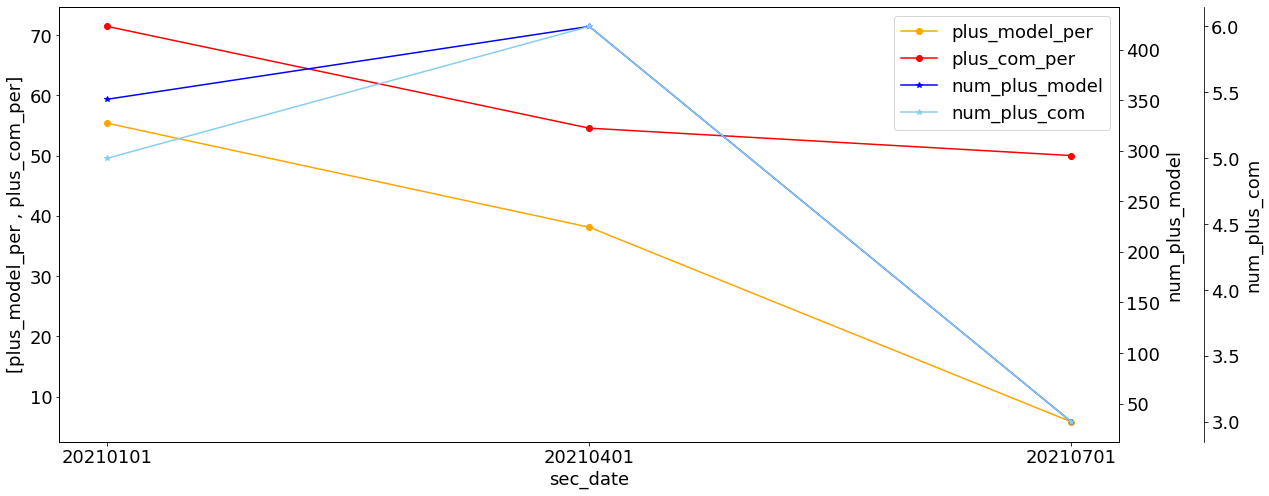

toda ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


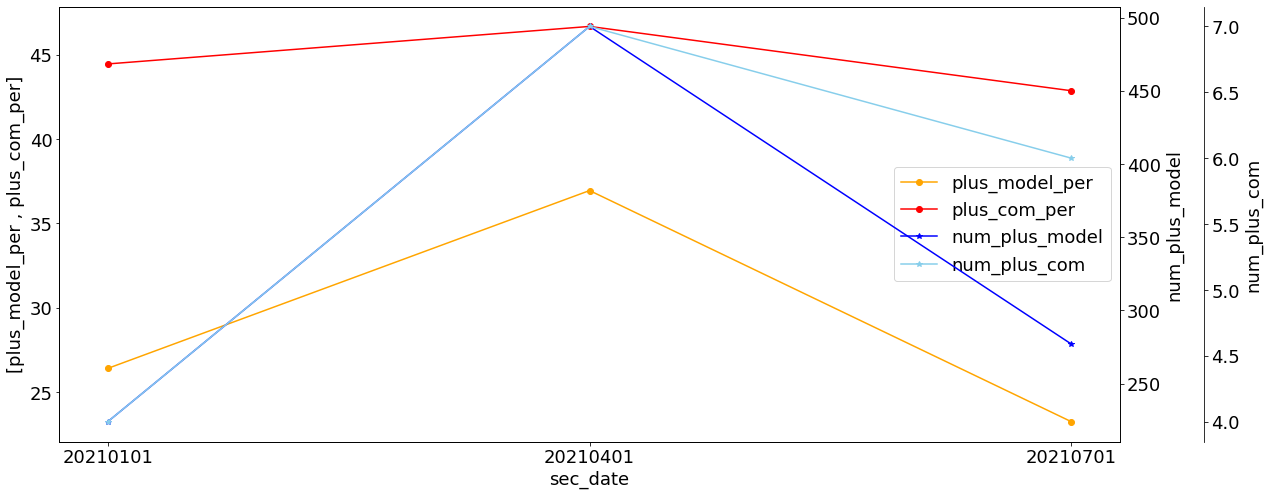

edogawa ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


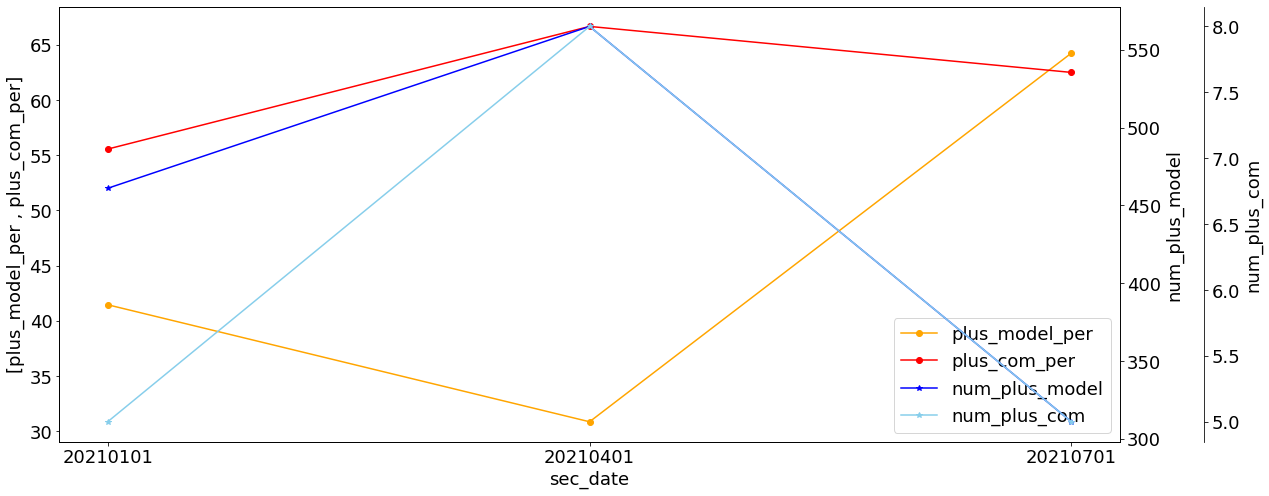

heiwazima ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


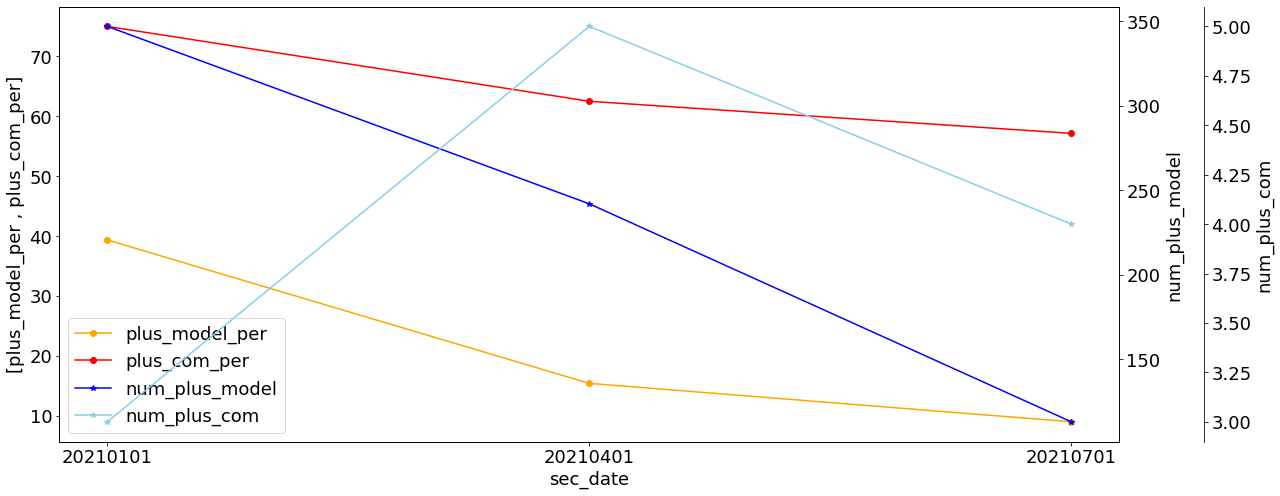

tamagawa ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


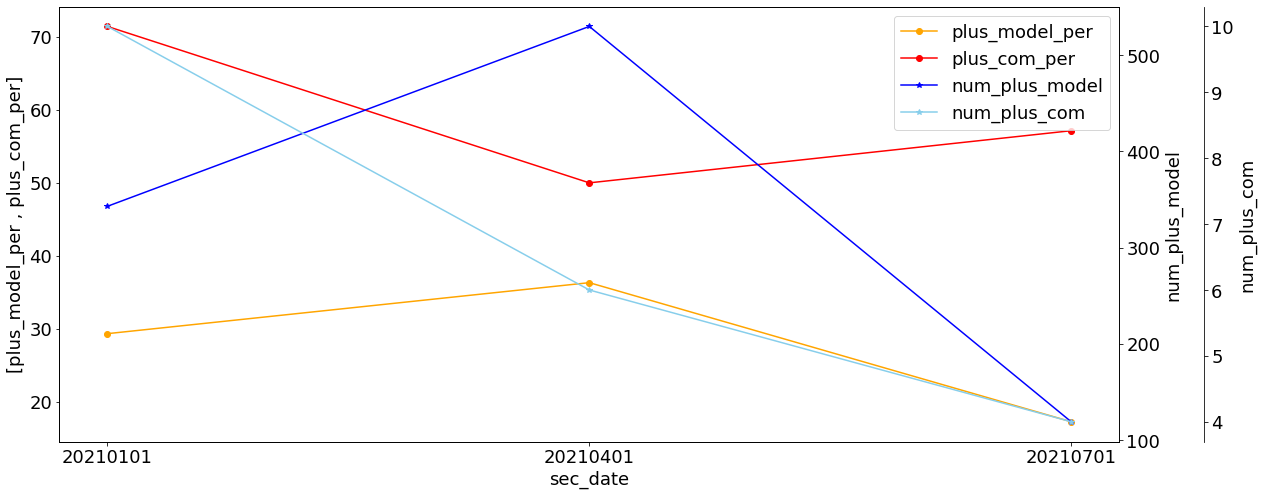

hamanako ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


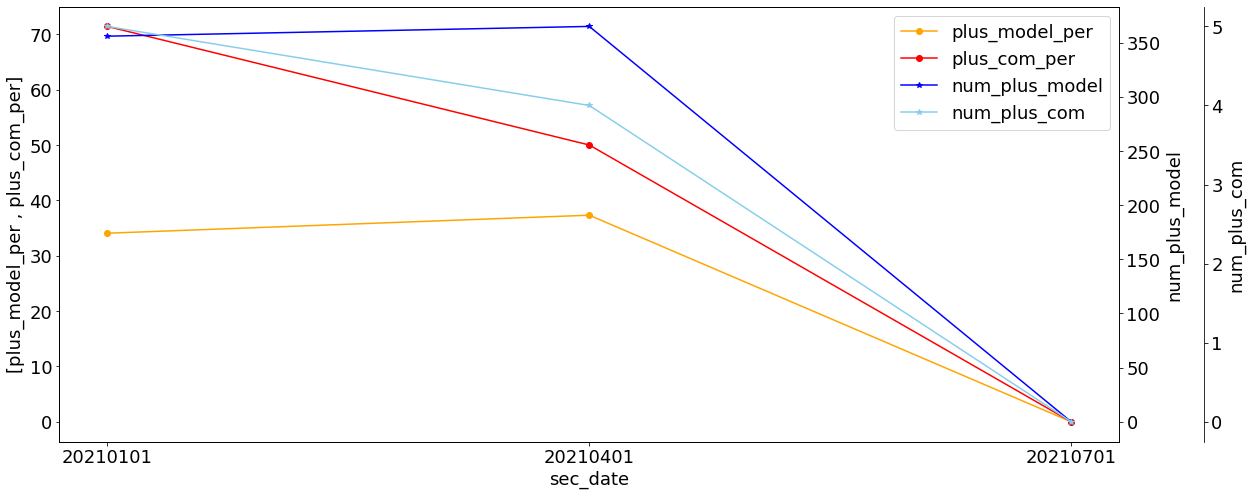

gamagori ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


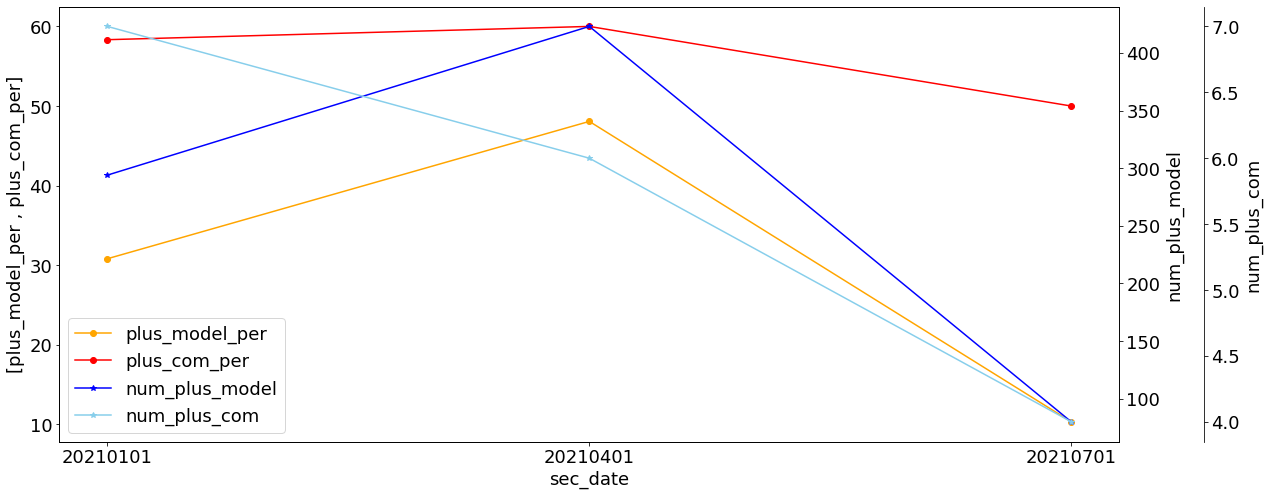

tokoname ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


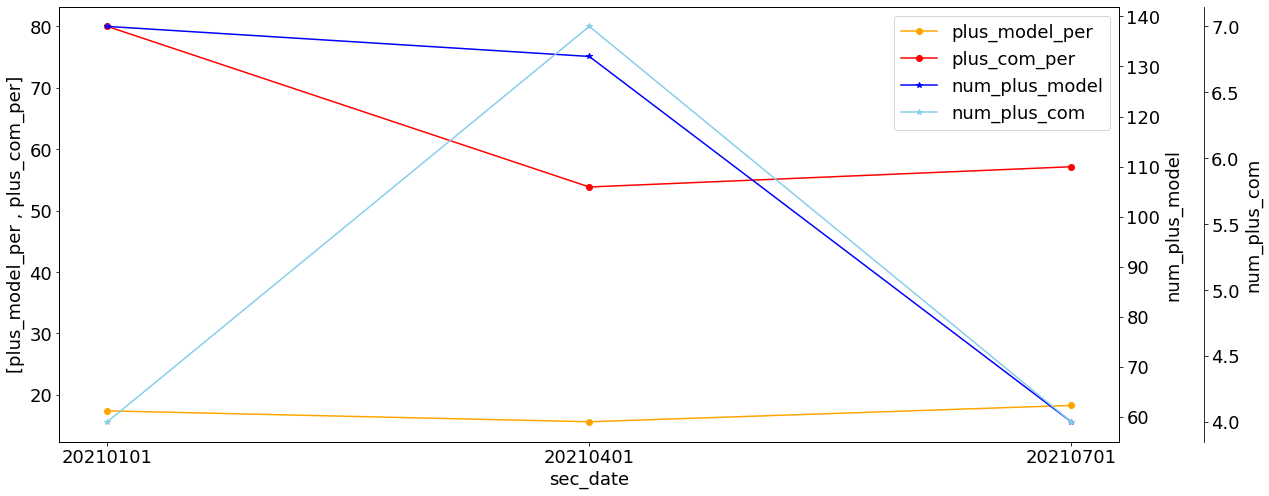

tu ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


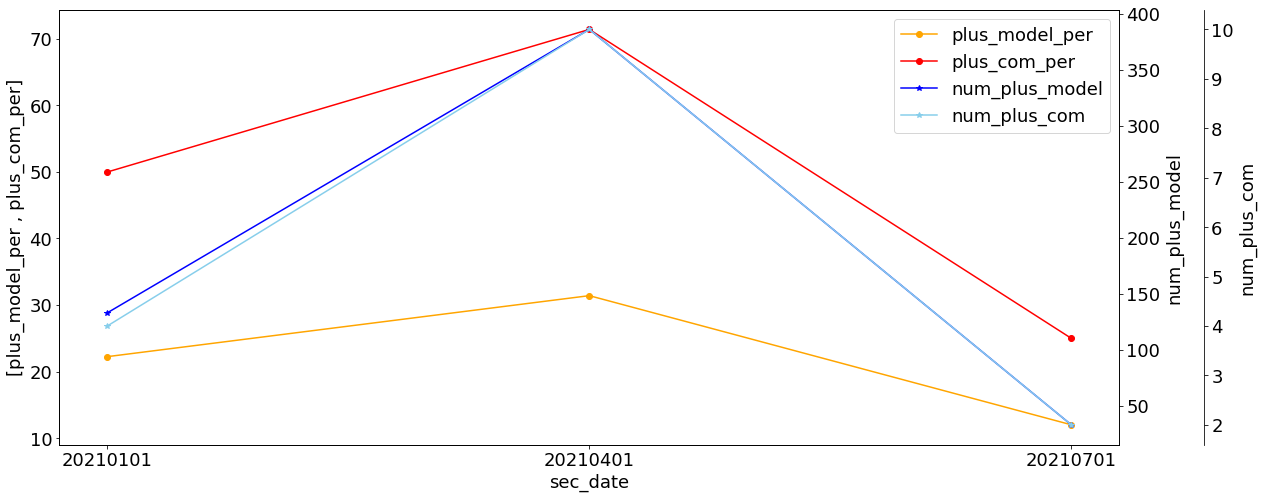

mikuni ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


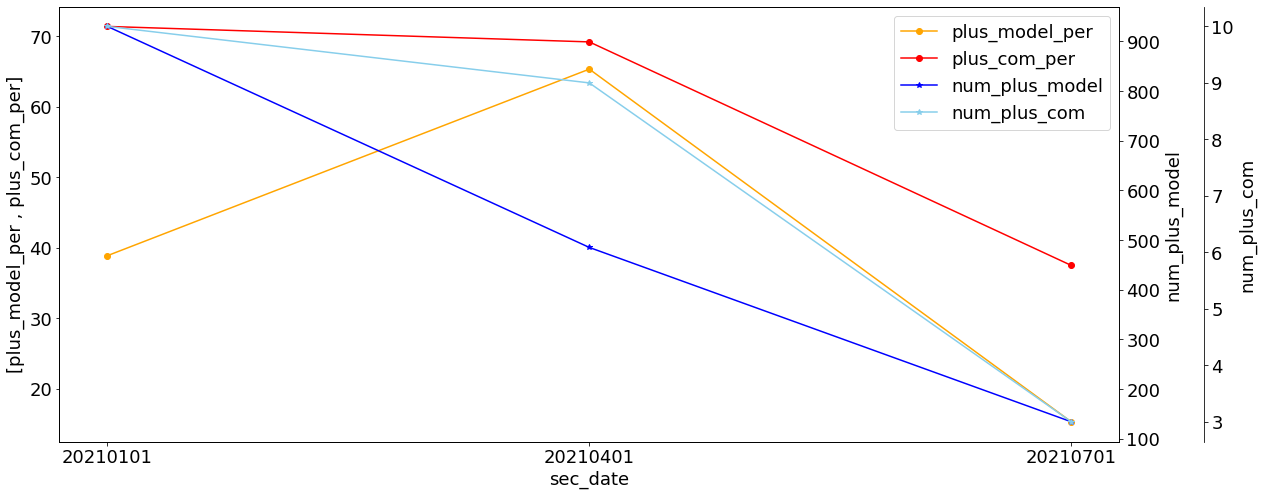

biwako ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


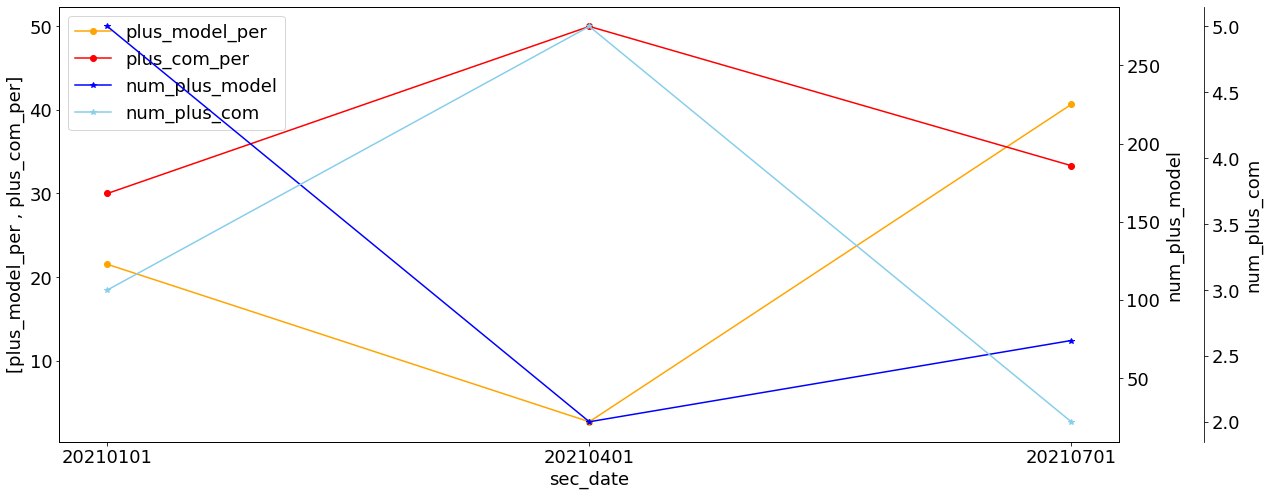

suminoe ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


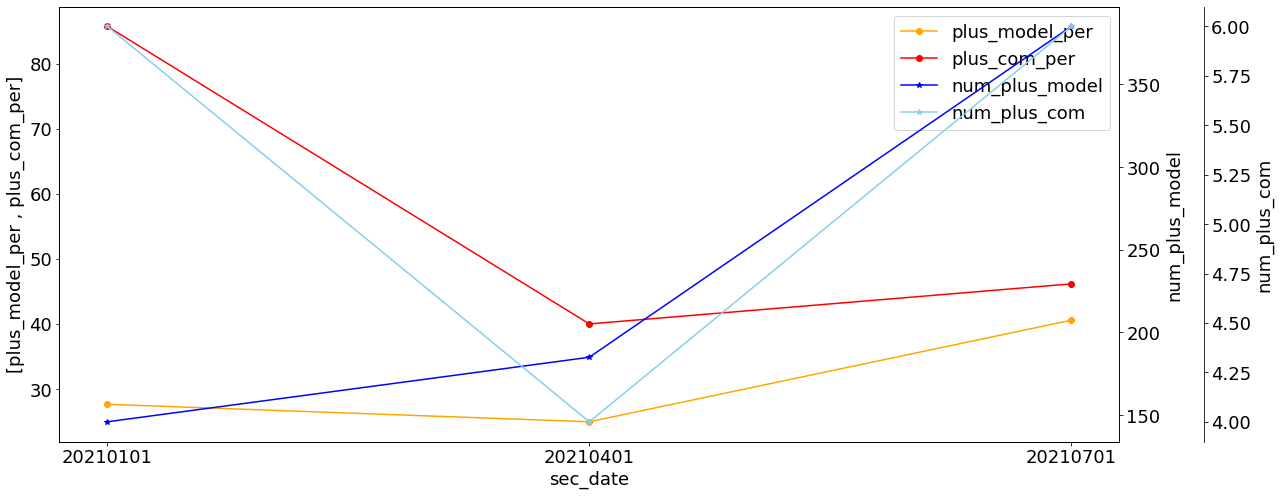

amagasaki ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


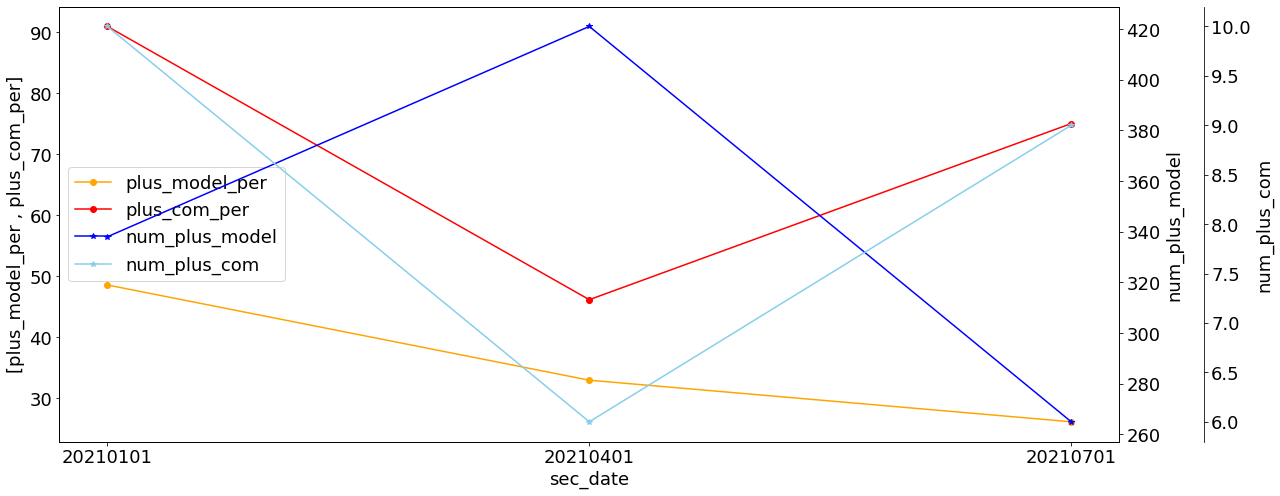

naruto ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


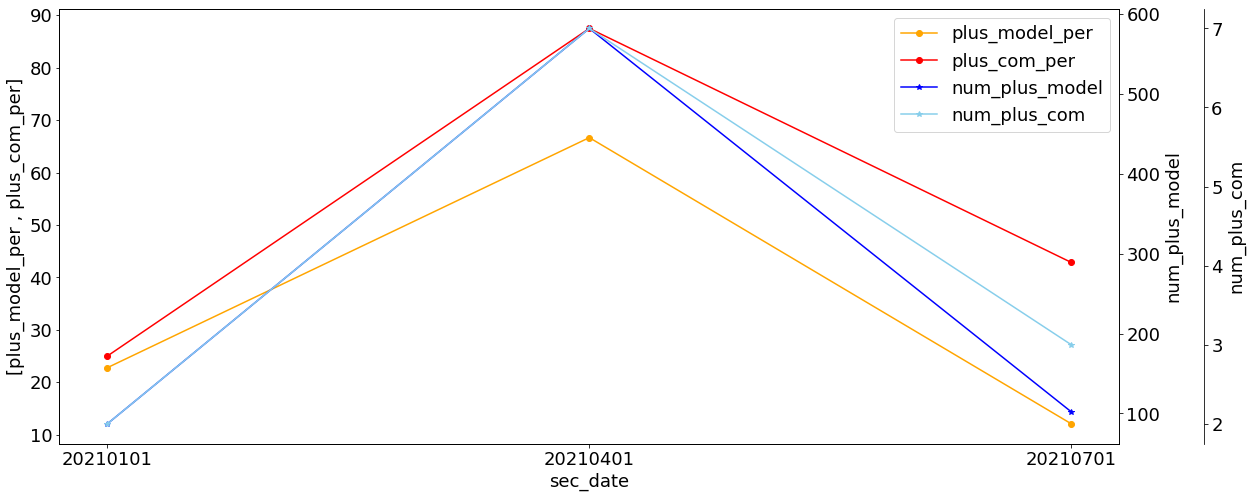

marugame ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


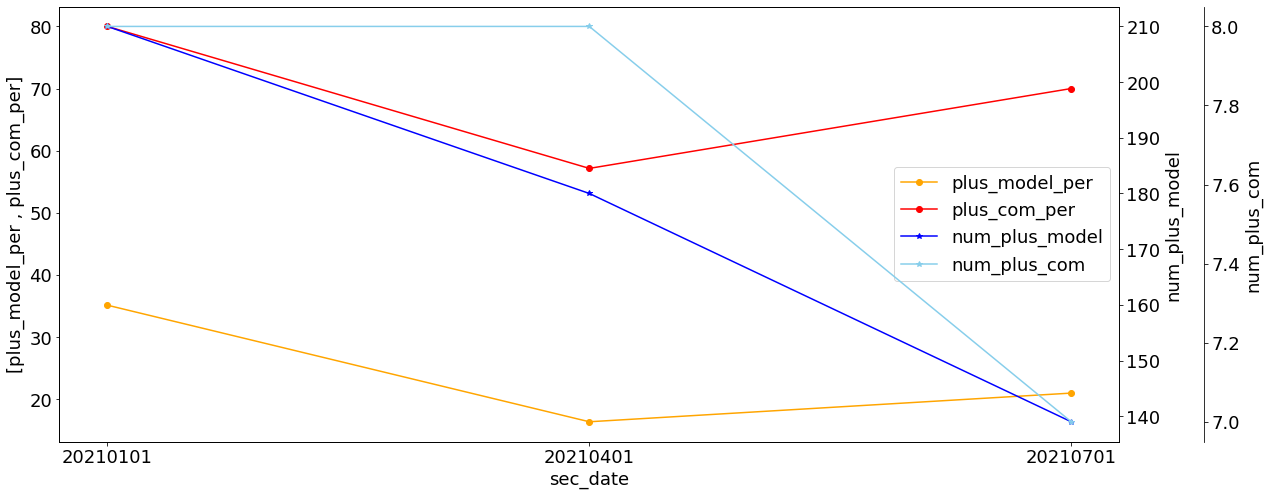

kozima ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


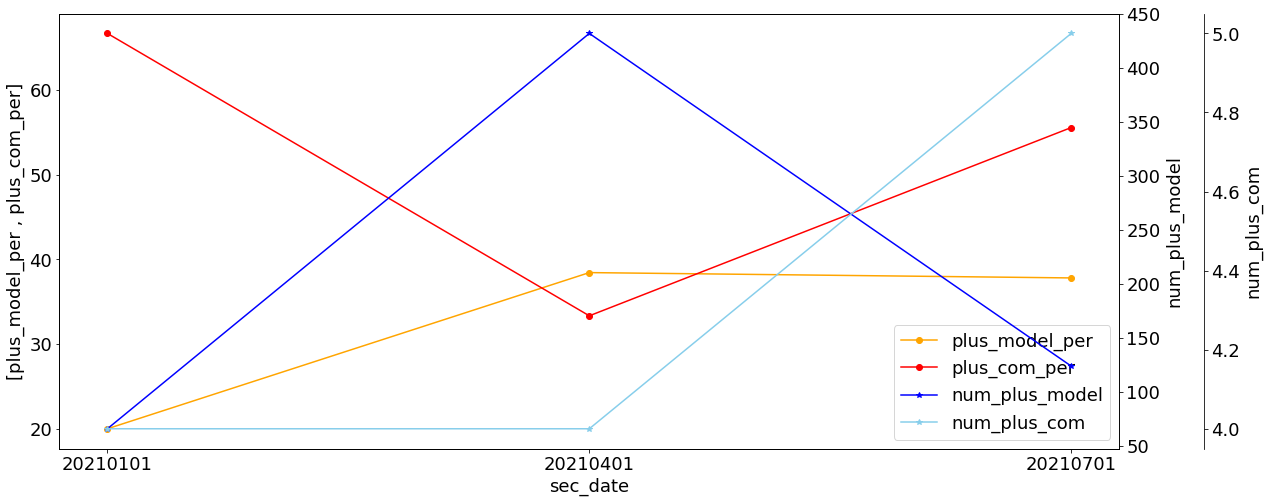

miyazima ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


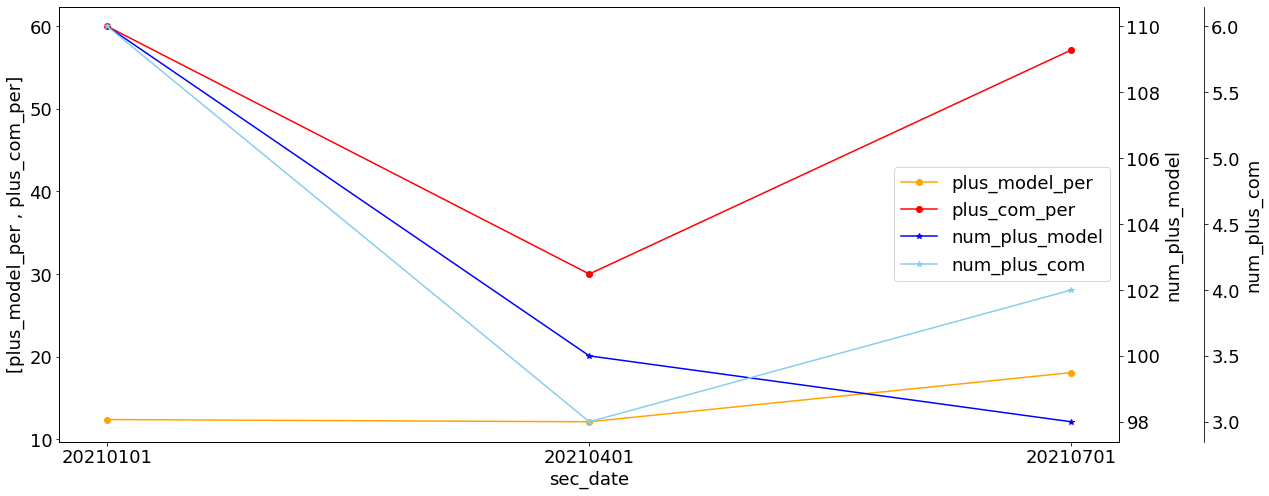

tokuyama ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


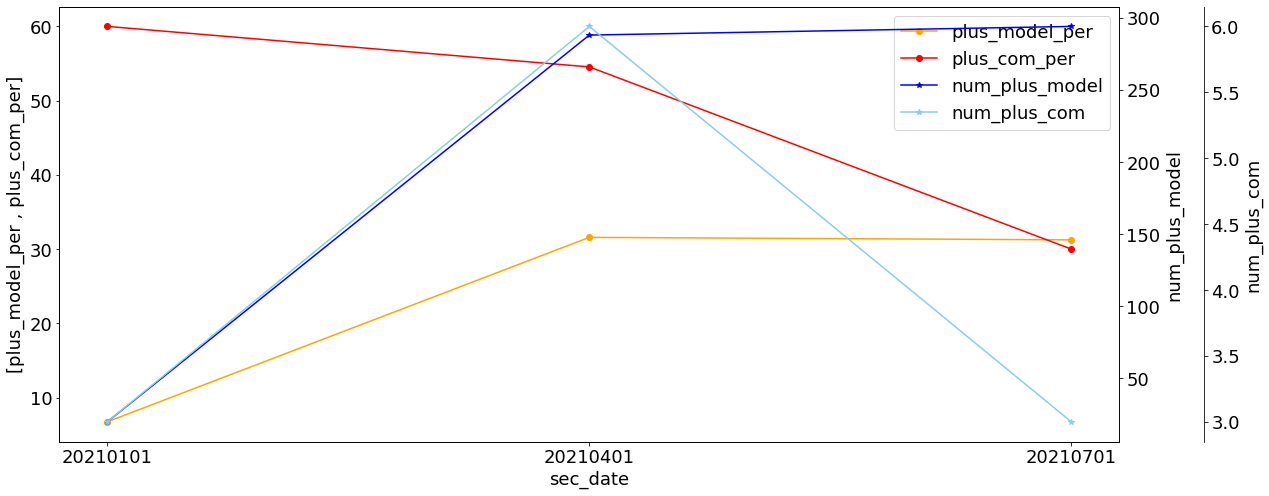

simonoseki ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


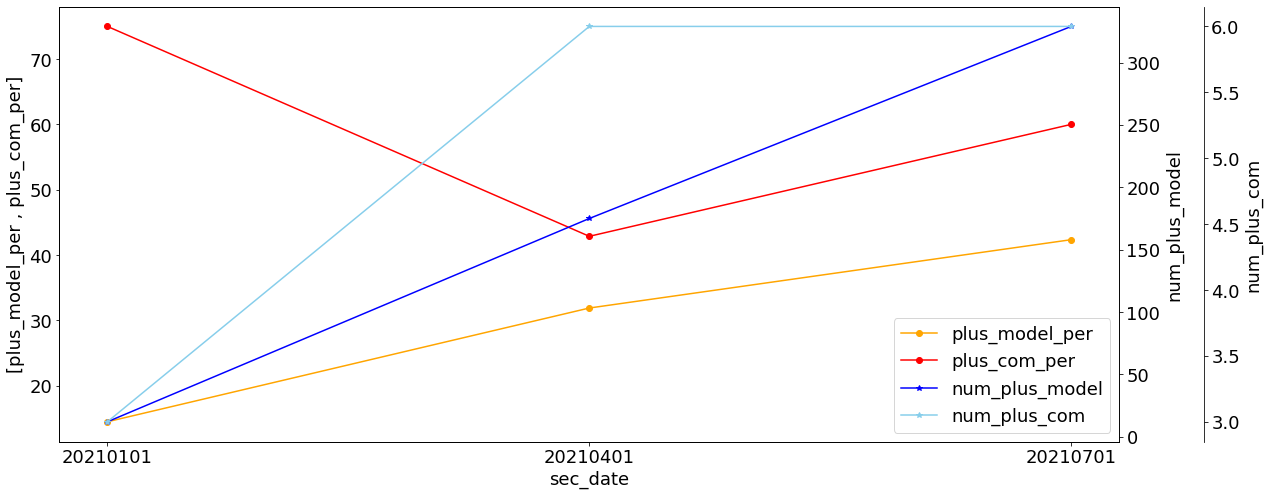

wakamatu ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


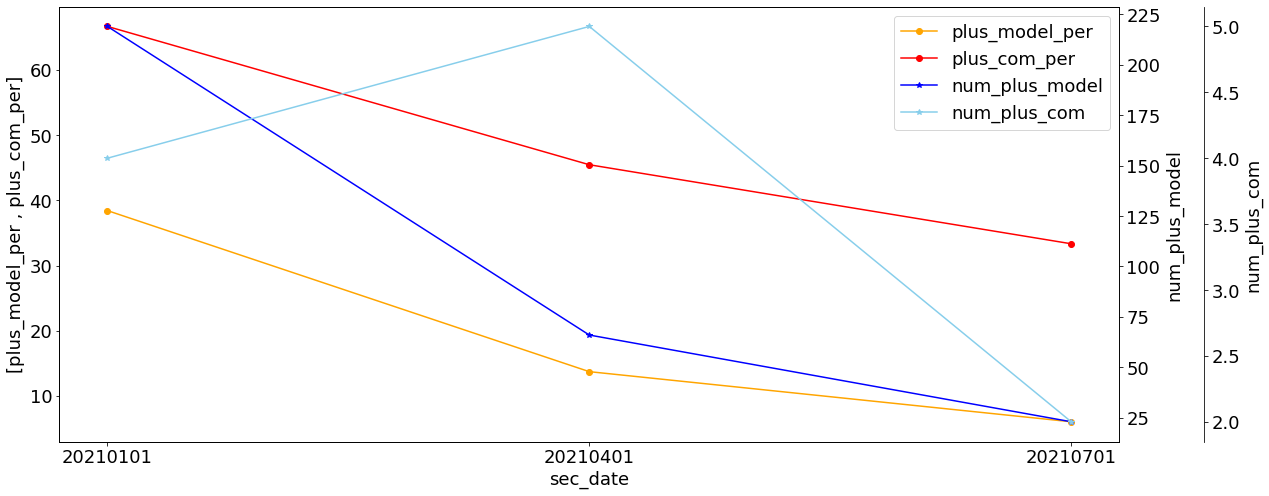

asiya ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


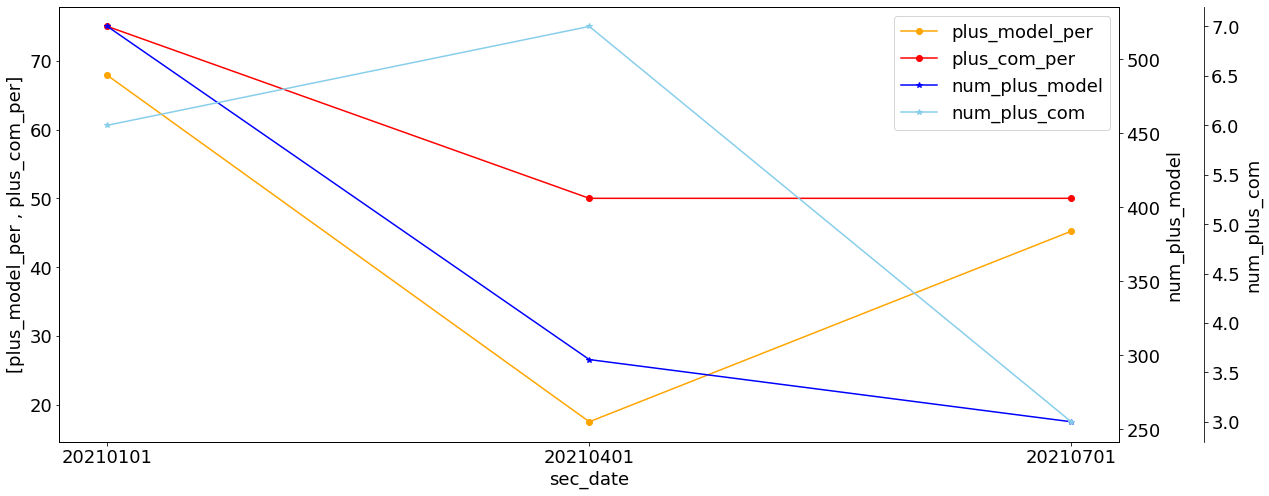

fukuoka ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


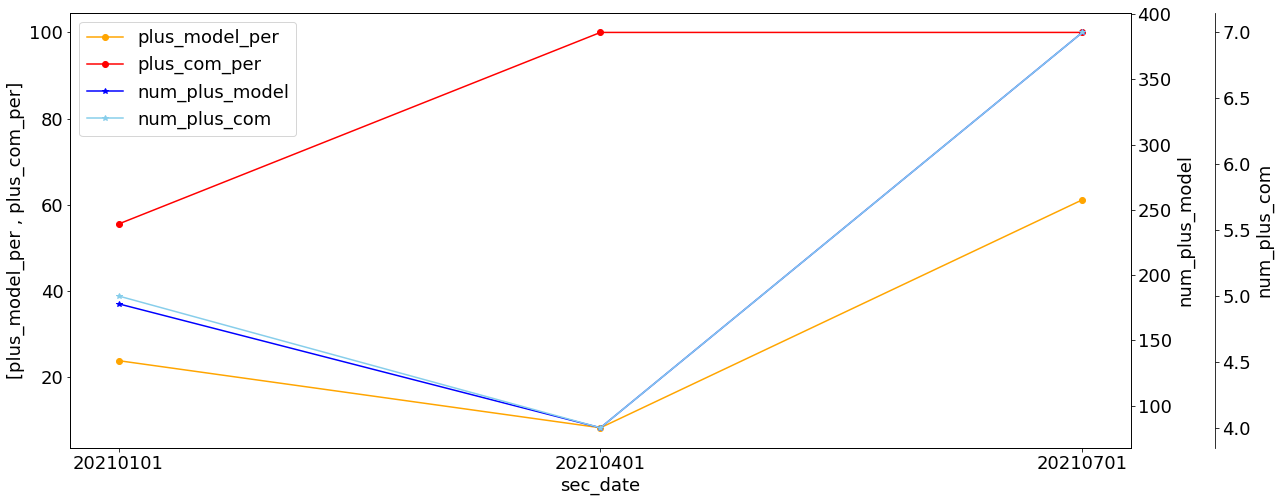

karatu ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


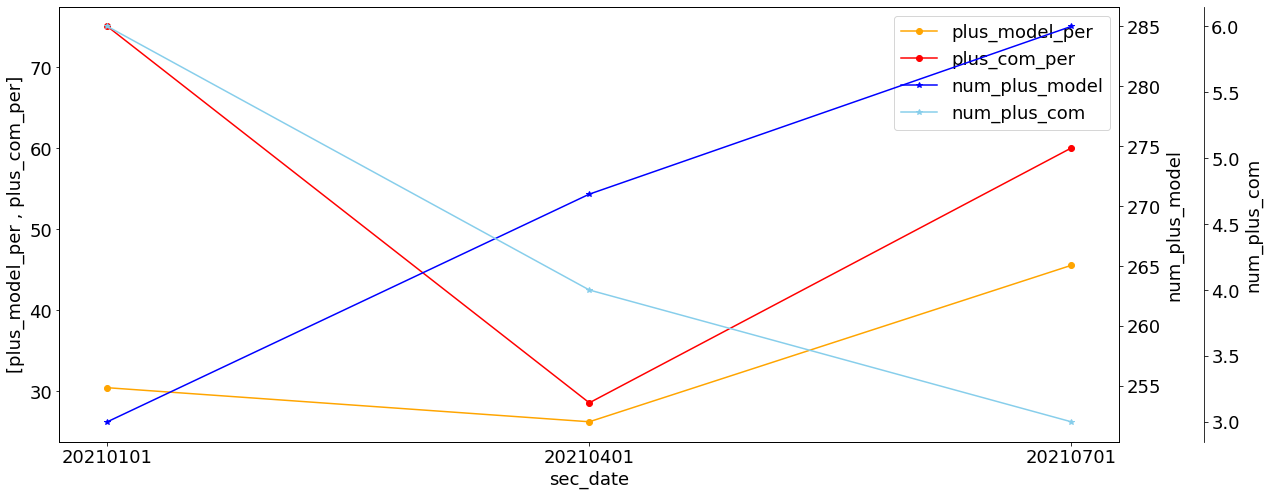

omura ===============================================================


<ipython-input-45-4b8d49003a51>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


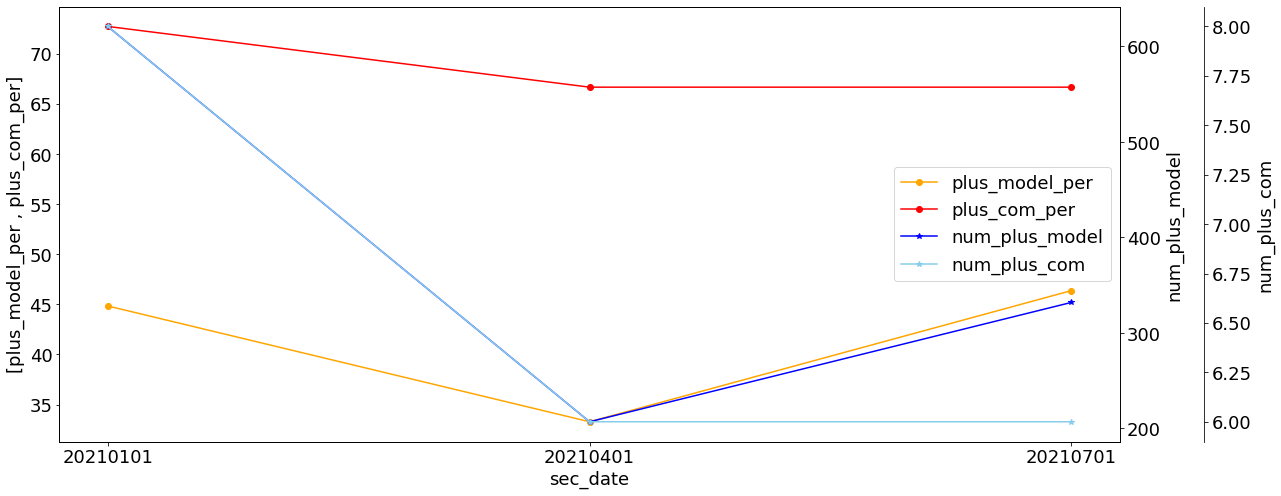

In [49]:
place_master=master.get_place_master()
place_names=[place_name for place_name in place_master.values()]#会場名のみを収納した配列
#絶対に固定のパラメータたち
plus_m_th=1

num_hit_th=3
version='V4_2'
mode='model_score_period_'
mode_type='period'
#today=datetime.date.today()#今日の日付の取得
today=datetime.datetime(year=2021, month=10,day=1)
now_date=today
for place_name in place_names:
    #place_name='heiwazima'
    print(place_name,'===============================================================')
    analysis_df=pd.DataFrame(columns=['sec_date','num_plus_model','plus_model_per','num_plus_com','plus_com_per'])

    #     diff_sec_dates=get_4_section_dt(now_date)#直近４区間の開始日をリストで取得
    #     now_date_txt=now_date.strftime('%Y%m%d')
    #     diff_sec_dates=diff_sec_dates[1:]#テスト時のみの特別処理！！データが１区間だけ足りないので今回はスルーする
    #閾値にあてはまった　モデルたちがどんな奴らなのかを確認する
    for i in range(3):
        #i=0
        sec_date=datetime.datetime(year=2021, month=1+(i*3),day=1)
        sec_date_txt=sec_date.strftime('%Y%m%d')

        #昨年同月のfinalあり分析結果のシートから使えそうなcom，集団を作成し，パラメータが参照できるように切り抜く
        date_cal_last=sec_date- relativedelta(months=3)#昨年同月の区間の日付を切り抜く
        date_cal_last_txt=date_cal_last.strftime('%Y%m%d')
        dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{place_name}_{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=date_cal_last_txt,version=version)
        model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
        model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
        #今年のスコアシートと，昨年同月から選んだモデルたちを渡して，今年で使うモデルを切り抜く
        dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{place_name}_{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=sec_date_txt,version=version)
        now_model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')#今年のスコアシートの読み込み
        now_model_score_df=now_model_score_df.drop(["Unnamed: 0"],axis=1)
        #並べる順番を変える，閾値をはじめの方に持ってきた
        model_score_df=model_score_df.sort_values(['target_com', 'threshold','depth','target_per'])
        model_score_df = model_score_df.reset_index(drop=True)
        #print('before_drop[num_com]:',len(model_score_df))#収益で切り落とす前のモデル数
        both_plus_models=model_score_df[(model_score_df['gain_test']>100)&(model_score_df['gain_final']>100)].copy()#まずは昨年同月の，testとfinalともに利益が出ていたものを切り抜く
        #print('after_drop[num_com]:',len(both_plus_models))#収益で切り落とした後のモデル数
        models_has_g_num_df=serch_group(both_plus_models)#モデルのパラメータから集団番号を付与


        #試しに決めの値で集団長を指定して切り抜く（どの程度利益の出ているモデル,comがあるのか）
        len_th=5
        g_num_len=models_has_g_num_df['group_num'].value_counts()#集団番号ごとの長さ
        numbers_g_s=g_num_len.loc[g_num_len>=len_th]#集団の長さが閾値以上のものをvalue_counts()の結果から切り抜く
        group_df=pd.DataFrame()
        for g_num in numbers_g_s.index:
            target_g_num_df=models_has_g_num_df[models_has_g_num_df['group_num']==g_num]
            group_df=pd.concat([group_df,target_g_num_df])

        #可能性分析
        same_param_models_df=get_same_para_model(group_df,now_model_score_df)
        add_s=get_num_plus_model_com(same_param_models_df)
        add_s['sec_date']=sec_date_txt
        analysis_df=analysis_df.append(add_s,ignore_index=True)
    x_n='sec_date'
    y1_1_n='plus_model_per'
    y1_2_n='plus_com_per'
    y2_1_n='num_plus_model'
    y2_2_n='num_plus_com'
    df_triple_plt(analysis_df,x_n,y1_1_n,y1_2_n,y2_1_n,y2_2_n)
    plt.close()
        #display(analysis_df)
    #         print('last_year===========================================================================================')
    #         display(group_df)

    #         print('now_year===========================================================================================')
    #         display(same_param_models_df)





    #         #集団の真ん中のモデルを切り抜く
    #         g_nums_counts=group_df['group_num'].value_counts(sort=False)
    #         center_models_df=pd.DataFrame(columns=group_df.columns)#真ん中で切り抜いたモデルのか格納先
    #         for index,len_group in g_nums_counts.items():
    #             model_groups_df=group_df[group_df['group_num']==index].copy()
    #             target_row=model_groups_df.iloc[int(len_group)-1]
    #             center_models_df=center_models_df.append(target_row)

    #         #絶対的な的中数でさらにモデルを切り抜く
    #         hit_th=5
    #         good_models_df=center_models_df[(center_models_df['num_hit_test']>hit_th) & (center_models_df['num_hit_final']>hit_th)].copy()
    #         #good_models_df=center_models_df[(center_models_df['num_hit_test']>2) & (center_models_df['num_hit_final']>2)].copy()
    #         selected_models_df=pd.DataFrame(columns=group_df.columns)#真ん中で切り抜いたモデルのか格納先
    #         for com in good_models_df['target_com'].value_counts().index:
    #             good_models_com_df=good_models_df[good_models_df['target_com']==com].copy()
    #             good_models_com_row=good_models_com_df.sort_values(['num_hit_final','gain_final'],ascending=[False, False]).iloc[0]#的中数，finalゲインでsp－として一番大きいものにする
    #             selected_models_df=selected_models_df.append(good_models_com_row)




            #display(use_models_df['gain_final'])
    #same_param_models_df.to_csv('ex.csv')

